In [1]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [3]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [4]:
import pylogit as pl

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [6]:
size = 1500
path = '/content/drive/My Drive'
data1 = pd.read_pickle(f'{path}/CMAP/london_processed_raw.pkl')

# Restore the original dataset
col = ['age', 'male', 'driving_license', 'car_ownership', 'pt_n_interchanges', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_inv',
       'dur_pt_int_total', 'dur_driving', 'cost_transit', 'cost_driving_total']
train_df = pd.DataFrame(data1['X_train'], columns=col)
train_df['mode'] = data1['Y_train']
test_df = pd.DataFrame(data1['X_test'], columns=col)
test_df['mode'] = data1['Y_test']
data1 = pd.concat([train_df, test_df])
data1['dur_pt_total'] = data1['dur_pt_access'] + data1['dur_pt_inv'] + data1['dur_pt_int_total']
data1['dur_active'] = (data1['dur_walking'] + data1['dur_cycling']) / 2
data1['mode'] = data1['mode'].replace(0, 2).replace(3, 0)

data1['young'] = (data1['age'] < 25).astype(int)
data1['old'] = (data1['age'] > 55).astype(int)
data1['hhveh_1'] = (data1['car_ownership'] == 1).astype(int)

data1 = data1[['young', 'old', 'male', 'driving_license', 'car_ownership', 'hhveh_1', 'pt_n_interchanges', 'dur_driving', 'cost_driving_total',
               'dur_pt_total', 'cost_transit', 'dur_active', 'mode']].sample(size, random_state=9)
data1 = data1.rename(columns={'driving_license': 'license', 'car_ownership': 'hhveh', 'pt_n_interchanges': 'transfer', 'dur_driving': 'auto_time',
                              'dur_pt_total': 'transit_time', 'dur_active': 'active_time', 'cost_driving_total': 'auto_cost',
                              'cost_transit': 'transit_cost'})

var, alt = 'auto_cost', 0

In [7]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [8]:
train_size = 800
val_size = 200
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [9]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [10]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [11]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [13]:
l_alt = ['Auto', 'Transit', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [14]:
# Training set
true_share(data_train)

mode
Auto       0.431
Transit    0.369
Active     0.200
Name: proportion, dtype: float64

In [15]:
# Validation set
true_share(data_val)

mode
Auto       0.435
Transit    0.375
Active     0.190
Name: proportion, dtype: float64

In [16]:
# Test set
true_share(data_test)

mode
Auto       0.436
Transit    0.352
Active     0.212
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [17]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'transit', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:7]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'transit_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'transit_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_transit', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [18]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [19]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  young  old  male  license  hhveh  hhveh_1  \
0          1       0     0      1    0     1        1      1        1   
1          1       1     1      1    0     1        1      1        1   
2          1       2     0      1    0     1        1      1        1   
3          2       0     0      0    0     1        1      0        0   
4          2       1     1      0    0     1        1      0        0   
...      ...     ...   ...    ...  ...   ...      ...    ...      ...   
2395     799       1     0      0    1     0        1      1        1   
2396     799       2     0      0    1     0        1      1        1   
2397     800       0     1      0    0     1        1      2        0   
2398     800       1     0      0    0     1        1      2        0   
2399     800       2     0      0    0     1        1      2        0   

      transfer      time   cost  
0            1  1.051389   3.88  
1            1  1.160278   2.05  
2            1  3.845417   0.00  
3            0  0.739167  12.26  
4            0  0.703889   3.30  
...        ...       ...    ...  
2395         0  0.286389   0.00  
2396         0  0.352639   0.00  
2397         0  0.230000   0.71  
2398         0  0.575278   1.50  
2399         0  0.757083   0.00  

[2400 rows x 12 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [20]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_transit', 'asc_active']

# Individual-specific variables
spec['young'] = [1, 2]
name['young'] = ['young_transit', 'young_active']
spec['old'] = [1, 2]
name['old'] = ['old_transit', 'old_active']
spec['male'] = [1, 2]
name['male'] = ['male_transit', 'male_active']
spec['license'] = [1, 2]
name['license'] = ['license_transit', 'license_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_transit', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_transit', 'hhveh_1_active']
spec['transfer'] = [1, 2]
name['transfer'] = ['transfer_transit', 'transfer_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_transit', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_transit']

In [21]:
# for n in range(20, 40):
#     data1 = pd.read_pickle(f'{path}/CMAP/london_processed_raw.pkl')

#     # Restore the original dataset
#     col = ['age', 'male', 'driving_license', 'car_ownership', 'pt_n_interchanges', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_inv',
#         'dur_pt_int_total', 'dur_driving', 'cost_transit', 'cost_driving_total']
#     train_df = pd.DataFrame(data1['X_train'], columns=col)
#     train_df['mode'] = data1['Y_train']
#     test_df = pd.DataFrame(data1['X_test'], columns=col)
#     test_df['mode'] = data1['Y_test']
#     data1 = pd.concat([train_df, test_df])
#     data1['dur_pt_total'] = data1['dur_pt_access'] + data1['dur_pt_inv'] + data1['dur_pt_int_total']
#     data1['dur_active'] = (data1['dur_walking'] + data1['dur_cycling']) / 2
#     data1['mode'] = data1['mode'].replace(0, 2).replace(3, 0)

#     data1['young'] = (data1['age'] < 25).astype(int)
#     data1['old'] = (data1['age'] > 55).astype(int)
#     data1['hhveh_1'] = (data1['car_ownership'] == 1).astype(int)

#     data1 = data1[['young', 'old', 'male', 'driving_license', 'car_ownership', 'hhveh_1', 'pt_n_interchanges', 'dur_driving', 'cost_driving_total',
#                 'dur_pt_total', 'cost_transit', 'dur_active', 'mode']].sample(size, random_state=n)
#     data1 = data1.rename(columns={'driving_license': 'license', 'car_ownership': 'hhveh', 'pt_n_interchanges': 'transfer', 'dur_driving': 'auto_time',
#                                 'dur_pt_total': 'transit_time', 'dur_active': 'active_time', 'cost_driving_total': 'auto_cost',
#                                 'cost_transit': 'transit_cost'})

#     data1_train, data1_remain = data1[:train_size], data1[train_size:]
#     data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]
#     data1_train_lg = convert(data1_train)

#     mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='MNL', names=name)
#     mnl.fit_mle(np.zeros(21))
#     print(f'n = {n}, beta_train_cost = {mnl.params[-1]:.3f}\n')

In [22]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(21))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -878.8898
Initial Log-likelihood: -878.8898
Estimation Time for Point Estimation: 0.09 seconds.
Final log-likelihood: -570.2336


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                  800
Model:             Multinomial Logit Model   Df Residuals:                      779
Method:                                MLE   Df Model:                           21
Date:                     Tue, 09 Apr 2024   Pseudo R-squ.:                   0.351
Time:                             03:10:25   Pseudo R-bar-squ.:               0.327
AIC:                             1,182.467   Log-Likelihood:               -570.234
BIC:                             1,280.844   LL-Null:                      -878.890
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
asc_transit          2.1365      0.384      5.558      0.000       1.383       2.890
asc_active           3.0985      0.410      7.553      0.000       2.294       3.902
young_transit       -0.0516      0.317     -0.163      0.871      -0.673       0.570
young_active        -0.3579      0.360     -0.994      0.320      -1.063       0.348
old_transit          0.3243      0.292      1.111      0.267      -0.248       0.896
old_active          -0.0391      0.273     -0.144      0.886      -0.574       0.495
male_transit        -0.2725      0.208     -1.310      0.190      -0.680       0.135
male_active          0.3295      0.229      1.442      0.149      -0.118       0.778
license_transit     -1.2740      0.275     -4.629      0.000      -1.813      -0.735
license_active      -0.4517      0.320     -1.413      0.158      -1.078       0.175
hhveh_transit       -1.5253      0.170     -8.986      0.000      -1.858      -1.193
hhveh_active        -1.3096      0.191     -6.873      0.000      -1.683      -0.936
hhveh_1_transit     -0.9263      0.217     -4.272      0.000      -1.351      -0.501
hhveh_1_active      -0.8373      0.243     -3.452      0.001      -1.313      -0.362
transfer_transit    -0.2491      0.250     -0.996      0.319      -0.739       0.241
transfer_active      0.5223      0.382      1.366      0.172      -0.227       1.272
time_auto           -4.9769      0.931     -5.344      0.000      -6.802      -3.151
time_transit        -2.3668      0.665     -3.560      0.000      -3.670      -1.064
time_active         -7.0127      0.740     -9.481      0.000      -8.462      -5.563
cost_auto           -0.1170      0.046     -2.557      0.011      -0.207      -0.027
cost_transit         0.1156      0.104      1.108      0.268      -0.089       0.320
====================================================================================
"""

## Mixed logit (MXL)

In [23]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(26), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [24]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [25]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [26]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<6.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<6.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<6.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [27]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -570.2 | acc = 70.9% | F1 = 70.1%
Validation set: LL = -138.7 | acc = 70.0% | F1 = 68.9%
Test set:       LL = -331.2 | acc = 74.6% | F1 = 74.0%


In [28]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [29]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [30]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    # plt.show()
    plt.savefig(f'{path}/Regularity_results_L/{name}_1K_L.png', bbox_inches='tight', dpi=200)

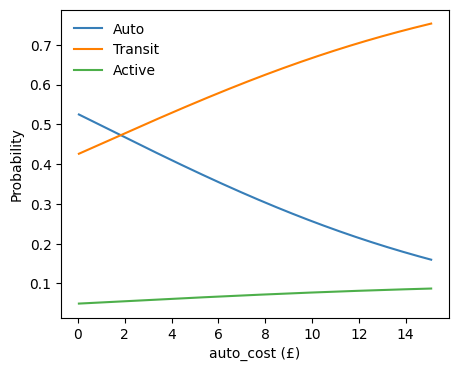

In [31]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [32]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [33]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [34]:
eps = (lower1 - upper1) / 2e6

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [35]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.998
Weak regularity   = 1.000


In [36]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [37]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [38]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 11]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 11]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 9:11]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 11]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [39]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [40]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [41]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [42]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [43]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [44]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [45]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_1K_L.png', bbox_inches='tight', dpi=200)
    else:
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_{lambd}_1K_L.png', bbox_inches='tight', dpi=200)
    plt.show()

In [46]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [47]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_1K_L.png', bbox_inches='tight', dpi=200)

In [48]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+15, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [49]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(12, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -509.1 | acc = 72.8% | F1 = 72.4%
Validation set: LL = -142.6 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -323.2 | acc = 74.2% | F1 = 73.9%
Model 2 
Training set:   LL = -501.2 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -146.2 | acc = 68.5% | F1 = 68.3%
Test set:       LL = -325.5 | acc = 72.8% | F1 = 72.6%
Model 3 
Training set:   LL = -511.5 | acc = 73.0% | F1 = 72.4%
Validation set: LL = -141.9 | acc = 69.5% | F1 = 68.7%
Test set:       LL = -325.4 | acc = 73.8% | F1 = 73.2%
Model 4 
Training set:   LL = -509.0 | acc = 72.6% | F1 = 72.1%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 68.2%
Test set:       LL = -325.2 | acc = 74.6% | F1 = 74.1%
Model 5 
Training set:   LL = -503.8 | acc = 73.2% | F1 = 72.7%
Validation set: LL = -146.8 | acc = 67.5% | F1 = 66.7%
Test set:       LL = -317.0 | acc = 74.0% | F1 = 73.5%
Model 6 
Training set:   LL = -509.1 | acc = 73.8% | F1 = 73.2%
Validation set: LL = -1

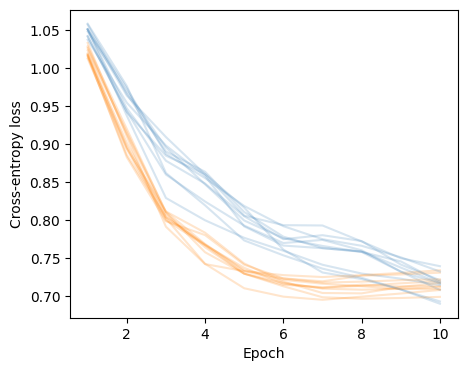

------------------------------ 
Training set:
Average log-likelihood = -506.5 (4.0)
Average accuracy       = 73.2% (0.5%)
Average F1 score       = 72.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -143.3 (2.0)
Average accuracy       = 68.8% (0.8%)
Average F1 score       = 68.3% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -322.6 (3.5)
Average accuracy       = 73.7% (0.7%)
Average F1 score       = 73.2% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.898 (0.072)
Weak regularity   = 0.905 (0.072)
------------------------------ 
Validation set:
Strong regularity = 0.889 (0.073)
Weak regularity   = 0.895 (0.073)
------------------------------ 
Test set:
Strong regularity = 0.904 (0.069)
Weak regularity   = 0.913 (0.067)
------------------------------


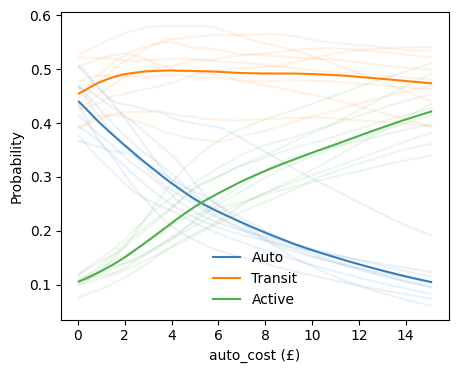

In [50]:
result(DNN, 10, 'none')

### PGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -537.0 | acc = 71.1% | F1 = 70.2%
Validation set: LL = -139.4 | acc = 66.5% | F1 = 64.5%
Test set:       LL = -339.0 | acc = 72.4% | F1 = 71.2%
Model 2 
Training set:   LL = -524.7 | acc = 71.4% | F1 = 70.1%
Validation set: LL = -139.6 | acc = 68.5% | F1 = 66.7%
Test set:       LL = -328.3 | acc = 72.0% | F1 = 70.5%
Model 3 
Training set:   LL = -537.4 | acc = 72.2% | F1 = 71.3%
Validation set: LL = -143.2 | acc = 67.0% | F1 = 65.2%
Test set:       LL = -331.6 | acc = 72.2% | F1 = 71.2%
Model 4 
Training set:   LL = -536.4 | acc = 70.9% | F1 = 70.6%
Validation set: LL = -147.5 | acc = 64.5% | F1 = 64.2%
Test set:       LL = -337.7 | acc = 71.0% | F1 = 70.6%
Model 5 
Training set:   LL = -522.9 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -142.0 | acc = 71.0% | F1 = 70.7%
Test set:       LL = -329.8 | acc = 72.0% | F1 = 71.7%
Model 6 
Training set:   LL = -556.7 | acc = 68.1% | F1 = 63.4%
Validation set: LL = -

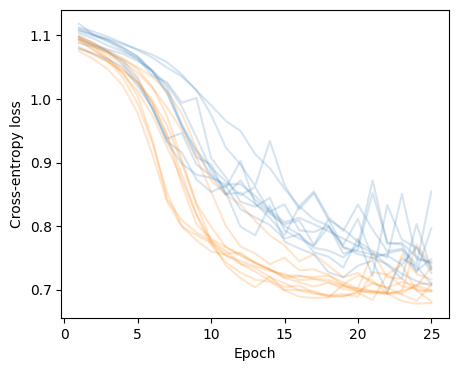

------------------------------ 
Training set:
Average log-likelihood = -530.1 (14.8)
Average accuracy       = 71.4% (1.4%)
Average F1 score       = 70.0% (2.7%)
------------------------------ 
Validation set:
Average log-likelihood = -141.2 (3.7)
Average accuracy       = 67.9% (2.2%)
Average F1 score       = 66.1% (3.1%)
------------------------------ 
Test set:
Average log-likelihood = -336.0 (11.2)
Average accuracy       = 71.1% (1.7%)
Average F1 score       = 69.4% (3.2%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 1.000 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 1.000 (0.001)
------------------------------


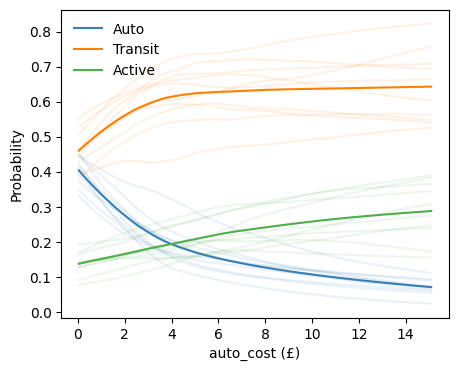

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -555.3 | acc = 69.4% | F1 = 67.8%
Validation set: LL = -141.2 | acc = 66.0% | F1 = 63.3%
Test set:       LL = -334.1 | acc = 72.4% | F1 = 70.8%
Model 2 
Training set:   LL = -549.6 | acc = 70.4% | F1 = 68.9%
Validation set: LL = -136.2 | acc = 67.5% | F1 = 65.5%
Test set:       LL = -332.9 | acc = 71.4% | F1 = 69.4%
Model 3 
Training set:   LL = -544.4 | acc = 70.6% | F1 = 69.1%
Validation set: LL = -138.2 | acc = 67.5% | F1 = 65.6%
Test set:       LL = -327.7 | acc = 70.4% | F1 = 68.2%
Model 4 
Training set:   LL = -541.3 | acc = 71.0% | F1 = 69.6%
Validation set: LL = -138.8 | acc = 67.0% | F1 = 65.1%
Test set:       LL = -325.6 | acc = 72.2% | F1 = 71.0%
Model 5 
Training set:   LL = -538.6 | acc = 70.6% | F1 = 69.6%
Validation set: LL = -139.5 | acc = 68.0% | F1 = 66.6%
Test set:       LL = -325.1 | acc = 72.0% | F1 = 70.6%
Model 6 
Training set:   LL = -536.5 | acc = 71.0% | F1 = 69.8%
Validation set: LL = -1

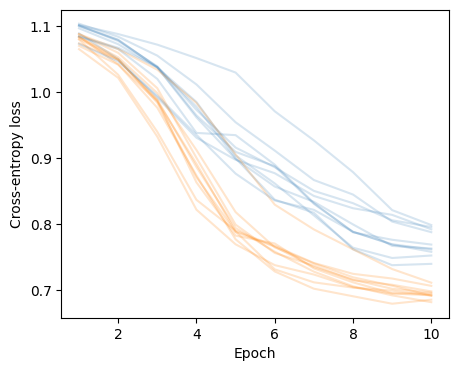

------------------------------ 
Training set:
Average log-likelihood = -542.9 (11.9)
Average accuracy       = 70.7% (1.0%)
Average F1 score       = 69.4% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -138.9 (1.7)
Average accuracy       = 68.1% (1.5%)
Average F1 score       = 66.3% (1.9%)
------------------------------ 
Test set:
Average log-likelihood = -328.8 (8.1)
Average accuracy       = 72.0% (1.3%)
Average F1 score       = 70.3% (2.0%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.001)
------------------------------


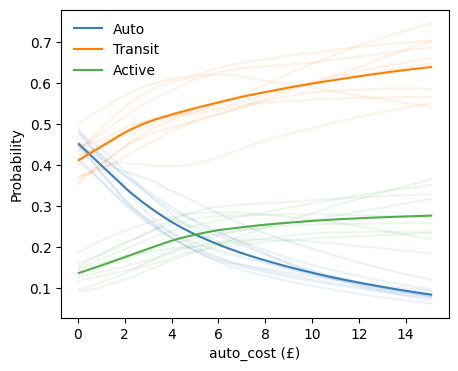

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -521.4 | acc = 72.5% | F1 = 71.8%
Validation set: LL = -137.2 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -321.6 | acc = 73.0% | F1 = 72.2%
Model 2 
Training set:   LL = -508.8 | acc = 72.9% | F1 = 72.0%
Validation set: LL = -137.7 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -321.8 | acc = 73.8% | F1 = 73.2%
Model 3 
Training set:   LL = -509.1 | acc = 72.4% | F1 = 71.7%
Validation set: LL = -137.5 | acc = 68.5% | F1 = 67.9%
Test set:       LL = -317.4 | acc = 73.4% | F1 = 72.7%
Model 4 
Training set:   LL = -511.6 | acc = 72.6% | F1 = 71.7%
Validation set: LL = -141.1 | acc = 68.5% | F1 = 67.7%
Test set:       LL = -318.8 | acc = 73.8% | F1 = 73.1%
Model 5 
Training set:   LL = -503.4 | acc = 73.8% | F1 = 73.2%
Validation set: LL = -141.1 | acc = 70.0% | F1 = 69.3%
Test set:       LL = -315.6 | acc = 73.8% | F1 = 73.3%
Model 6 
Training set:   LL = -509.5 | acc = 72.8% | F1 = 72.0%
Validation set: LL = 

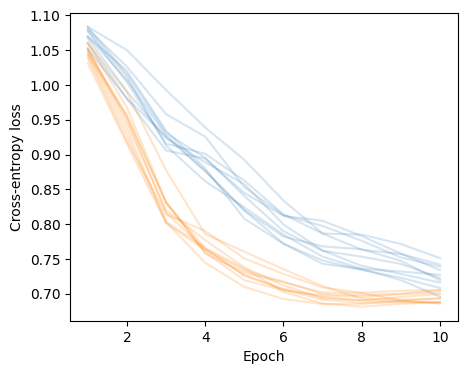

------------------------------ 
Training set:
Average log-likelihood = -509.0 (6.4)
Average accuracy       = 73.2% (0.8%)
Average F1 score       = 72.5% (0.9%)
------------------------------ 
Validation set:
Average log-likelihood = -139.0 (1.5)
Average accuracy       = 69.3% (0.9%)
Average F1 score       = 68.6% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -319.0 (3.9)
Average accuracy       = 73.7% (0.7%)
Average F1 score       = 73.0% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.988 (0.006)
Weak regularity   = 0.992 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.985 (0.012)
Weak regularity   = 0.987 (0.011)
------------------------------ 
Test set:
Strong regularity = 0.989 (0.007)
Weak regularity   = 0.992 (0.006)
------------------------------


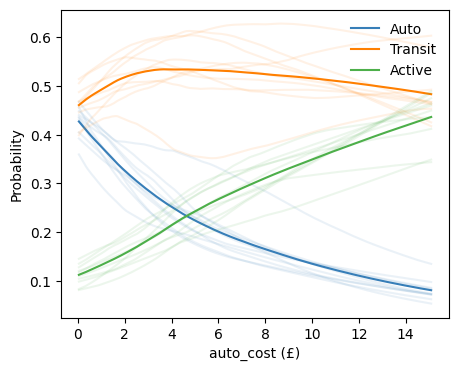

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -514.1 | acc = 72.4% | F1 = 71.9%
Validation set: LL = -138.7 | acc = 69.5% | F1 = 69.0%
Test set:       LL = -320.5 | acc = 72.6% | F1 = 72.0%
Model 2 
Training set:   LL = -498.7 | acc = 74.4% | F1 = 73.7%
Validation set: LL = -140.6 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -321.7 | acc = 73.8% | F1 = 73.2%
Model 3 
Training set:   LL = -509.0 | acc = 73.1% | F1 = 72.5%
Validation set: LL = -139.0 | acc = 69.5% | F1 = 68.8%
Test set:       LL = -318.6 | acc = 73.8% | F1 = 73.0%
Model 4 
Training set:   LL = -506.6 | acc = 72.8% | F1 = 72.1%
Validation set: LL = -142.8 | acc = 69.0% | F1 = 68.4%
Test set:       LL = -320.9 | acc = 73.2% | F1 = 72.6%
Model 5 
Training set:   LL = -497.1 | acc = 73.2% | F1 = 72.6%
Validation set: LL = -142.5 | acc = 70.0% | F1 = 69.2%
Test set:       LL = -313.2 | acc = 73.0% | F1 = 72.4%
Model 6 
Training set:   LL = -505.5 | acc = 73.6% | F1 = 73.0%
Validation set: LL =

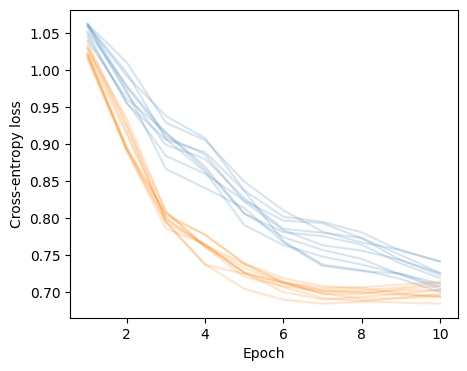

------------------------------ 
Training set:
Average log-likelihood = -505.4 (5.5)
Average accuracy       = 73.3% (0.5%)
Average F1 score       = 72.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -140.1 (1.8)
Average accuracy       = 69.2% (0.9%)
Average F1 score       = 68.6% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -319.0 (3.3)
Average accuracy       = 73.5% (0.6%)
Average F1 score       = 72.9% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.024)
Weak regularity   = 0.953 (0.022)
------------------------------ 
Validation set:
Strong regularity = 0.934 (0.028)
Weak regularity   = 0.941 (0.026)
------------------------------ 
Test set:
Strong regularity = 0.950 (0.026)
Weak regularity   = 0.959 (0.025)
------------------------------


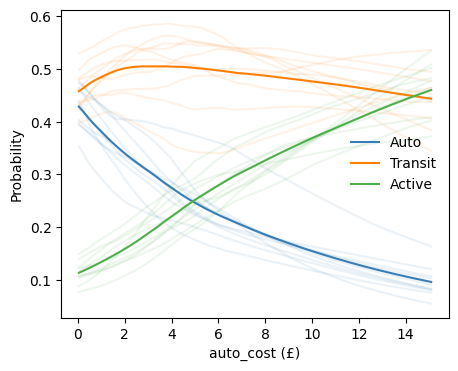

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -509.1 | acc = 72.8% | F1 = 72.3%
Validation set: LL = -140.8 | acc = 69.0% | F1 = 68.4%
Test set:       LL = -320.6 | acc = 74.0% | F1 = 73.7%
Model 2 
Training set:   LL = -501.9 | acc = 73.4% | F1 = 72.8%
Validation set: LL = -143.6 | acc = 70.0% | F1 = 69.5%
Test set:       LL = -322.1 | acc = 73.8% | F1 = 73.3%
Model 3 
Training set:   LL = -510.5 | acc = 73.0% | F1 = 72.4%
Validation set: LL = -140.4 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -322.7 | acc = 73.2% | F1 = 72.5%
Model 4 
Training set:   LL = -507.0 | acc = 73.6% | F1 = 73.0%
Validation set: LL = -143.1 | acc = 69.5% | F1 = 68.6%
Test set:       LL = -322.8 | acc = 73.6% | F1 = 73.1%
Model 5 
Training set:   LL = -502.3 | acc = 73.2% | F1 = 72.6%
Validation set: LL = -145.0 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -314.0 | acc = 73.4% | F1 = 72.8%
Model 6 
Training set:   LL = -508.4 | acc = 73.4% | F1 = 72.8%
Validation set: LL 

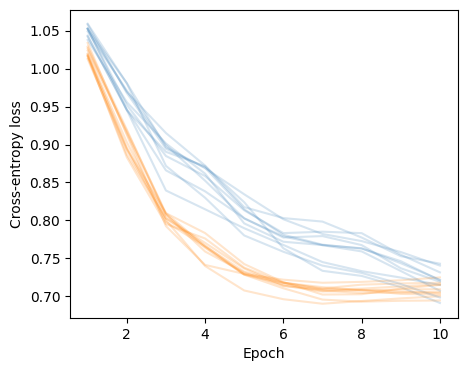

------------------------------ 
Training set:
Average log-likelihood = -506.1 (3.8)
Average accuracy       = 73.2% (0.4%)
Average F1 score       = 72.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -141.8 (1.8)
Average accuracy       = 69.0% (0.5%)
Average F1 score       = 68.3% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -320.3 (3.3)
Average accuracy       = 73.7% (0.6%)
Average F1 score       = 73.1% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.914 (0.057)
Weak regularity   = 0.920 (0.055)
------------------------------ 
Validation set:
Strong regularity = 0.899 (0.067)
Weak regularity   = 0.905 (0.067)
------------------------------ 
Test set:
Strong regularity = 0.916 (0.056)
Weak regularity   = 0.925 (0.054)
------------------------------


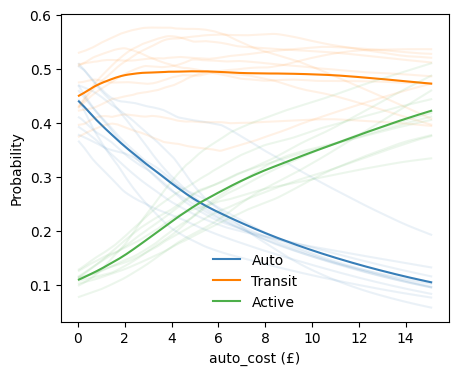

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -508.8 | acc = 72.8% | F1 = 72.4%
Validation set: LL = -142.5 | acc = 69.5% | F1 = 69.0%
Test set:       LL = -323.0 | acc = 74.4% | F1 = 74.1%
Model 2 
Training set:   LL = -500.8 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -145.6 | acc = 69.0% | F1 = 68.7%
Test set:       LL = -324.8 | acc = 73.0% | F1 = 72.7%
Model 3 
Training set:   LL = -511.3 | acc = 72.8% | F1 = 72.1%
Validation set: LL = -141.7 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -325.0 | acc = 73.4% | F1 = 72.7%
Model 4 
Training set:   LL = -508.0 | acc = 72.5% | F1 = 71.9%
Validation set: LL = -144.0 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -324.7 | acc = 74.4% | F1 = 73.9%
Model 5 
Training set:   LL = -504.1 | acc = 73.0% | F1 = 72.4%
Validation set: LL = -146.7 | acc = 68.0% | F1 = 67.3%
Test set:       LL = -316.5 | acc = 74.0% | F1 = 73.5%
Model 6 
Training set:   LL = -508.9 | acc = 73.5% | F1 = 72.9%
Validation set: LL

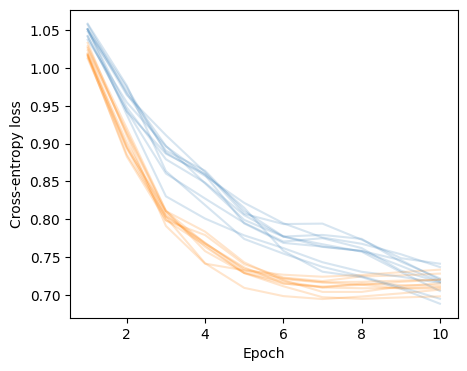

------------------------------ 
Training set:
Average log-likelihood = -506.3 (3.9)
Average accuracy       = 73.2% (0.6%)
Average F1 score       = 72.7% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -143.1 (2.0)
Average accuracy       = 69.1% (0.8%)
Average F1 score       = 68.5% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -322.3 (3.5)
Average accuracy       = 73.7% (0.7%)
Average F1 score       = 73.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.900 (0.067)
Weak regularity   = 0.909 (0.066)
------------------------------ 
Validation set:
Strong regularity = 0.890 (0.072)
Weak regularity   = 0.896 (0.068)
------------------------------ 
Test set:
Strong regularity = 0.904 (0.062)
Weak regularity   = 0.914 (0.061)
------------------------------


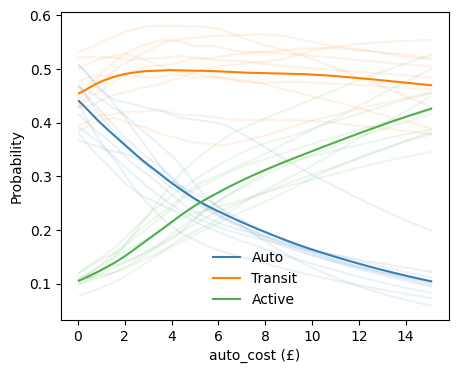

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -509.0 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -142.5 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -323.2 | acc = 74.4% | F1 = 74.1%
Model 2 
Training set:   LL = -502.2 | acc = 73.6% | F1 = 73.3%
Validation set: LL = -146.4 | acc = 68.5% | F1 = 68.3%
Test set:       LL = -325.8 | acc = 72.6% | F1 = 72.4%
Model 3 
Training set:   LL = -511.1 | acc = 72.6% | F1 = 72.0%
Validation set: LL = -141.8 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -325.2 | acc = 74.0% | F1 = 73.3%
Model 4 
Training set:   LL = -508.6 | acc = 72.6% | F1 = 72.1%
Validation set: LL = -144.1 | acc = 69.0% | F1 = 68.3%
Test set:       LL = -325.2 | acc = 74.4% | F1 = 73.9%
Model 5 
Training set:   LL = -503.9 | acc = 73.1% | F1 = 72.6%
Validation set: LL = -146.9 | acc = 67.5% | F1 = 66.9%
Test set:       LL = -316.9 | acc = 73.8% | F1 = 73.3%
Model 6 
Training set:   LL = -509.2 | acc = 73.8% | F1 = 73.2%
Validation set: LL 

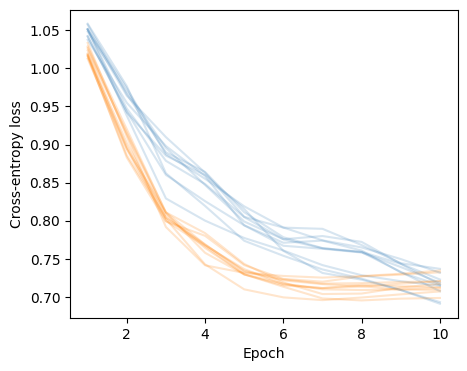

------------------------------ 
Training set:
Average log-likelihood = -506.5 (3.8)
Average accuracy       = 73.1% (0.6%)
Average F1 score       = 72.6% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -143.3 (2.1)
Average accuracy       = 68.8% (0.8%)
Average F1 score       = 68.2% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -322.5 (3.5)
Average accuracy       = 73.7% (0.9%)
Average F1 score       = 73.3% (0.9%)
------------------------------ 
Training set:
Strong regularity = 0.900 (0.067)
Weak regularity   = 0.908 (0.065)
------------------------------ 
Validation set:
Strong regularity = 0.887 (0.071)
Weak regularity   = 0.901 (0.068)
------------------------------ 
Test set:
Strong regularity = 0.903 (0.063)
Weak regularity   = 0.912 (0.062)
------------------------------


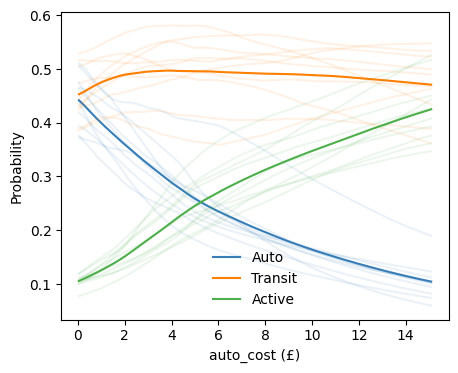

------------------------------ 
Model comparison:


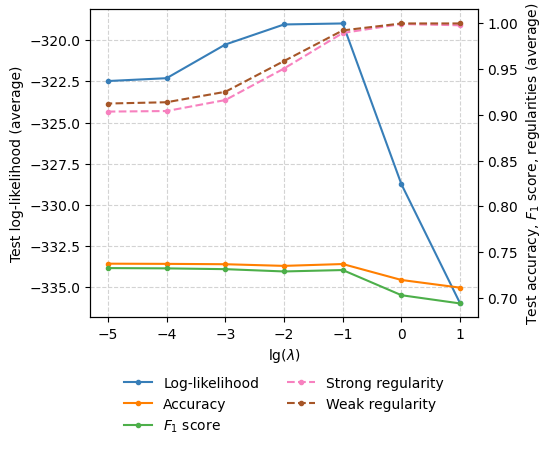

In [51]:
# With sum
result(DNN, 10, 'PGR', [10**i for i in range(1, -6, -1)])

### UGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -541.4 | acc = 72.0% | F1 = 71.2%
Validation set: LL = -139.9 | acc = 69.5% | F1 = 68.3%
Test set:       LL = -325.0 | acc = 73.2% | F1 = 72.3%
Model 2 
Training set:   LL = -553.0 | acc = 70.0% | F1 = 68.7%
Validation set: LL = -141.6 | acc = 67.5% | F1 = 65.5%
Test set:       LL = -339.5 | acc = 71.6% | F1 = 70.2%
Model 3 
Training set:   LL = -553.0 | acc = 70.8% | F1 = 69.8%
Validation set: LL = -142.3 | acc = 70.0% | F1 = 68.4%
Test set:       LL = -332.1 | acc = 71.2% | F1 = 70.1%
Model 4 
Training set:   LL = -538.4 | acc = 71.8% | F1 = 71.2%
Validation set: LL = -146.6 | acc = 67.5% | F1 = 66.8%
Test set:       LL = -329.8 | acc = 72.4% | F1 = 71.9%
Model 5 
Training set:   LL = -535.0 | acc = 71.5% | F1 = 70.7%
Validation set: LL = -142.6 | acc = 69.5% | F1 = 68.4%
Test set:       LL = -325.9 | acc = 73.0% | F1 = 72.4%
Model 6 
Training set:   LL = -524.7 | acc = 71.6% | F1 = 70.7%
Validation set: LL = -

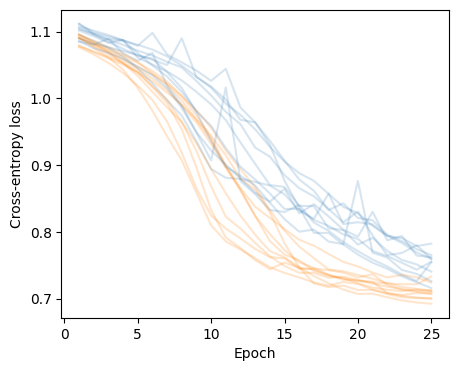

------------------------------ 
Training set:
Average log-likelihood = -540.9 (10.8)
Average accuracy       = 71.2% (0.7%)
Average F1 score       = 70.3% (0.9%)
------------------------------ 
Validation set:
Average log-likelihood = -142.0 (2.2)
Average accuracy       = 69.6% (1.4%)
Average F1 score       = 68.3% (1.6%)
------------------------------ 
Test set:
Average log-likelihood = -329.4 (6.4)
Average accuracy       = 72.5% (1.1%)
Average F1 score       = 71.6% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.006)
Weak regularity   = 0.997 (0.006)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 0.998 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.007)
Weak regularity   = 0.997 (0.007)
------------------------------


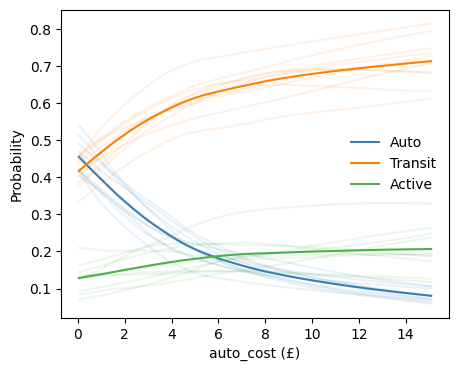

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -577.1 | acc = 68.8% | F1 = 67.4%
Validation set: LL = -143.4 | acc = 67.5% | F1 = 64.9%
Test set:       LL = -338.1 | acc = 71.4% | F1 = 70.0%
Model 2 
Training set:   LL = -582.8 | acc = 67.8% | F1 = 64.9%
Validation set: LL = -143.1 | acc = 67.0% | F1 = 62.5%
Test set:       LL = -344.1 | acc = 68.8% | F1 = 65.2%
Model 3 
Training set:   LL = -591.2 | acc = 66.4% | F1 = 63.1%
Validation set: LL = -144.1 | acc = 67.5% | F1 = 63.3%
Test set:       LL = -346.5 | acc = 69.6% | F1 = 65.6%
Model 4 
Training set:   LL = -571.4 | acc = 69.5% | F1 = 68.4%
Validation set: LL = -144.2 | acc = 70.0% | F1 = 68.4%
Test set:       LL = -334.0 | acc = 73.2% | F1 = 72.1%
Model 5 
Training set:   LL = -572.9 | acc = 69.5% | F1 = 68.2%
Validation set: LL = -143.6 | acc = 67.5% | F1 = 64.8%
Test set:       LL = -334.5 | acc = 71.8% | F1 = 70.2%
Model 6 
Training set:   LL = -580.1 | acc = 67.1% | F1 = 63.8%
Validation set: LL = -1

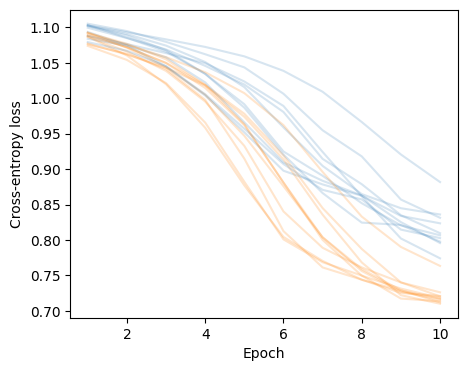

------------------------------ 
Training set:
Average log-likelihood = -582.4 (12.5)
Average accuracy       = 67.8% (1.6%)
Average F1 score       = 65.1% (2.9%)
------------------------------ 
Validation set:
Average log-likelihood = -144.3 (2.9)
Average accuracy       = 67.6% (1.5%)
Average F1 score       = 64.0% (2.7%)
------------------------------ 
Test set:
Average log-likelihood = -342.9 (9.4)
Average accuracy       = 70.3% (1.7%)
Average F1 score       = 67.1% (3.3%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


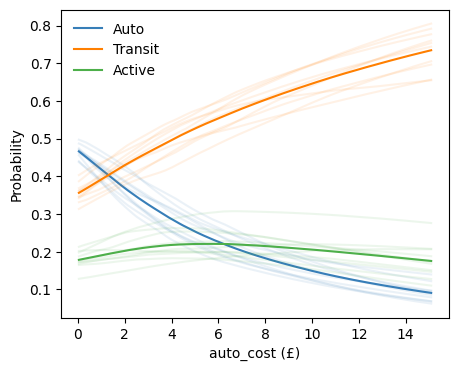

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -528.3 | acc = 72.2% | F1 = 71.7%
Validation set: LL = -138.6 | acc = 68.5% | F1 = 67.6%
Test set:       LL = -319.5 | acc = 74.0% | F1 = 73.4%
Model 2 
Training set:   LL = -514.4 | acc = 73.2% | F1 = 72.6%
Validation set: LL = -138.4 | acc = 70.5% | F1 = 69.8%
Test set:       LL = -320.0 | acc = 73.0% | F1 = 72.3%
Model 3 
Training set:   LL = -516.1 | acc = 72.4% | F1 = 71.7%
Validation set: LL = -139.4 | acc = 68.0% | F1 = 67.0%
Test set:       LL = -315.9 | acc = 73.0% | F1 = 72.3%
Model 4 
Training set:   LL = -524.1 | acc = 72.8% | F1 = 72.2%
Validation set: LL = -141.5 | acc = 67.5% | F1 = 66.7%
Test set:       LL = -318.8 | acc = 74.2% | F1 = 73.7%
Model 5 
Training set:   LL = -516.0 | acc = 72.0% | F1 = 71.4%
Validation set: LL = -141.8 | acc = 69.5% | F1 = 68.9%
Test set:       LL = -315.2 | acc = 74.0% | F1 = 73.5%
Model 6 
Training set:   LL = -517.8 | acc = 72.2% | F1 = 71.6%
Validation set: LL = 

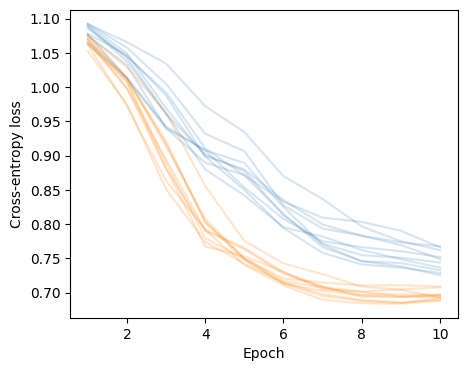

------------------------------ 
Training set:
Average log-likelihood = -517.8 (6.6)
Average accuracy       = 72.7% (0.6%)
Average F1 score       = 72.0% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -139.2 (1.3)
Average accuracy       = 69.3% (1.5%)
Average F1 score       = 68.5% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -317.8 (3.4)
Average accuracy       = 74.0% (0.7%)
Average F1 score       = 73.4% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.015)
Weak regularity   = 0.994 (0.012)
------------------------------ 
Validation set:
Strong regularity = 0.988 (0.021)
Weak regularity   = 0.993 (0.016)
------------------------------ 
Test set:
Strong regularity = 0.992 (0.014)
Weak regularity   = 0.993 (0.014)
------------------------------


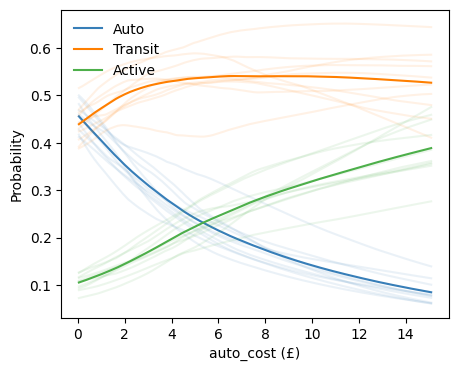

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -514.1 | acc = 73.2% | F1 = 72.9%
Validation set: LL = -137.9 | acc = 69.5% | F1 = 69.0%
Test set:       LL = -318.3 | acc = 74.0% | F1 = 73.7%
Model 2 
Training set:   LL = -499.3 | acc = 74.5% | F1 = 74.0%
Validation set: LL = -141.0 | acc = 70.5% | F1 = 69.9%
Test set:       LL = -319.7 | acc = 73.6% | F1 = 73.2%
Model 3 
Training set:   LL = -505.8 | acc = 72.5% | F1 = 72.0%
Validation set: LL = -139.5 | acc = 70.5% | F1 = 70.1%
Test set:       LL = -316.1 | acc = 74.0% | F1 = 73.6%
Model 4 
Training set:   LL = -509.7 | acc = 72.6% | F1 = 72.0%
Validation set: LL = -142.6 | acc = 67.5% | F1 = 66.8%
Test set:       LL = -319.6 | acc = 74.2% | F1 = 73.7%
Model 5 
Training set:   LL = -501.5 | acc = 72.8% | F1 = 72.2%
Validation set: LL = -143.2 | acc = 69.0% | F1 = 68.6%
Test set:       LL = -315.5 | acc = 72.8% | F1 = 72.4%
Model 6 
Training set:   LL = -509.1 | acc = 72.9% | F1 = 72.3%
Validation set: LL =

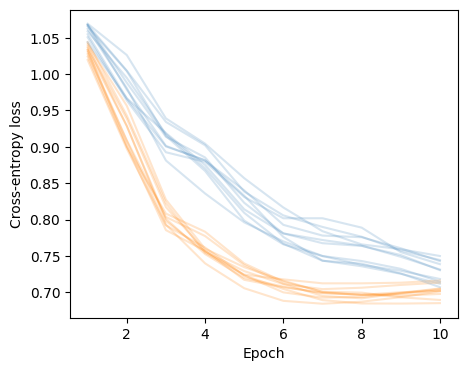

------------------------------ 
Training set:
Average log-likelihood = -505.4 (6.2)
Average accuracy       = 73.3% (0.7%)
Average F1 score       = 72.8% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -140.3 (1.8)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 69.1% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -317.4 (2.9)
Average accuracy       = 73.8% (0.6%)
Average F1 score       = 73.4% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.974 (0.022)
Weak regularity   = 0.979 (0.018)
------------------------------ 
Validation set:
Strong regularity = 0.963 (0.036)
Weak regularity   = 0.969 (0.032)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.020)
Weak regularity   = 0.981 (0.019)
------------------------------


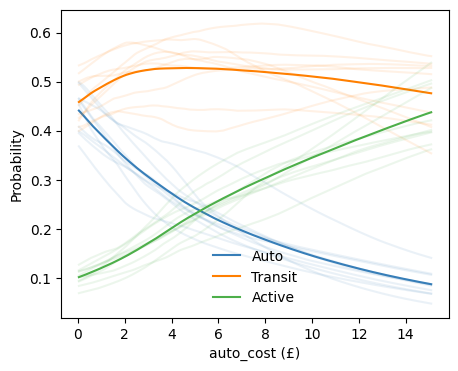

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -510.9 | acc = 72.9% | F1 = 72.5%
Validation set: LL = -139.7 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -319.2 | acc = 74.8% | F1 = 74.5%
Model 2 
Training set:   LL = -499.2 | acc = 73.6% | F1 = 73.1%
Validation set: LL = -142.8 | acc = 70.5% | F1 = 69.9%
Test set:       LL = -319.3 | acc = 73.8% | F1 = 73.3%
Model 3 
Training set:   LL = -509.7 | acc = 73.1% | F1 = 72.5%
Validation set: LL = -140.1 | acc = 69.5% | F1 = 68.8%
Test set:       LL = -320.7 | acc = 73.4% | F1 = 72.6%
Model 4 
Training set:   LL = -508.4 | acc = 72.8% | F1 = 72.0%
Validation set: LL = -143.8 | acc = 68.0% | F1 = 67.2%
Test set:       LL = -321.6 | acc = 74.2% | F1 = 73.7%
Model 5 
Training set:   LL = -500.7 | acc = 73.0% | F1 = 72.4%
Validation set: LL = -144.3 | acc = 68.5% | F1 = 68.0%
Test set:       LL = -312.4 | acc = 73.6% | F1 = 73.1%
Model 6 
Training set:   LL = -508.6 | acc = 73.2% | F1 = 72.6%
Validation set: LL 

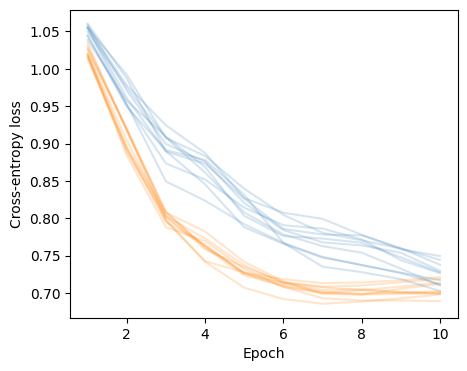

------------------------------ 
Training set:
Average log-likelihood = -505.7 (5.1)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.6% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -141.1 (2.0)
Average accuracy       = 69.2% (0.7%)
Average F1 score       = 68.6% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -318.4 (3.3)
Average accuracy       = 73.8% (0.5%)
Average F1 score       = 73.3% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.944 (0.035)
Weak regularity   = 0.950 (0.033)
------------------------------ 
Validation set:
Strong regularity = 0.935 (0.043)
Weak regularity   = 0.941 (0.042)
------------------------------ 
Test set:
Strong regularity = 0.947 (0.036)
Weak regularity   = 0.954 (0.034)
------------------------------


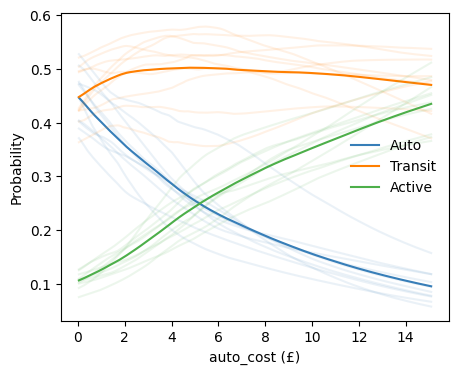

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -509.1 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -141.8 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -322.2 | acc = 73.6% | F1 = 73.3%
Model 2 
Training set:   LL = -501.3 | acc = 74.1% | F1 = 73.8%
Validation set: LL = -144.8 | acc = 69.0% | F1 = 68.7%
Test set:       LL = -323.5 | acc = 72.8% | F1 = 72.5%
Model 3 
Training set:   LL = -511.0 | acc = 73.1% | F1 = 72.5%
Validation set: LL = -141.7 | acc = 69.5% | F1 = 68.7%
Test set:       LL = -323.9 | acc = 73.6% | F1 = 73.0%
Model 4 
Training set:   LL = -508.1 | acc = 72.8% | F1 = 72.2%
Validation set: LL = -143.6 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -323.3 | acc = 74.0% | F1 = 73.5%
Model 5 
Training set:   LL = -503.4 | acc = 72.9% | F1 = 72.3%
Validation set: LL = -146.3 | acc = 67.0% | F1 = 66.3%
Test set:       LL = -315.6 | acc = 74.0% | F1 = 73.5%
Model 6 
Training set:   LL = -509.3 | acc = 73.2% | F1 = 72.6%
Validation set: LL

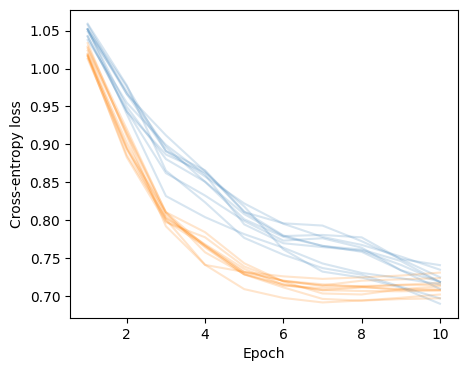

------------------------------ 
Training set:
Average log-likelihood = -506.2 (3.9)
Average accuracy       = 73.2% (0.6%)
Average F1 score       = 72.7% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -142.5 (1.9)
Average accuracy       = 68.8% (1.0%)
Average F1 score       = 68.3% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -321.2 (3.1)
Average accuracy       = 73.6% (0.5%)
Average F1 score       = 73.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.908 (0.063)
Weak regularity   = 0.917 (0.060)
------------------------------ 
Validation set:
Strong regularity = 0.895 (0.065)
Weak regularity   = 0.901 (0.067)
------------------------------ 
Test set:
Strong regularity = 0.912 (0.061)
Weak regularity   = 0.921 (0.060)
------------------------------


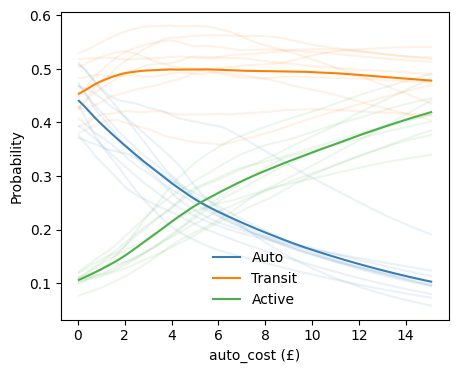

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -509.1 | acc = 72.6% | F1 = 72.2%
Validation set: LL = -142.6 | acc = 69.5% | F1 = 69.0%
Test set:       LL = -323.3 | acc = 74.4% | F1 = 74.1%
Model 2 
Training set:   LL = -501.6 | acc = 74.1% | F1 = 73.8%
Validation set: LL = -145.7 | acc = 69.0% | F1 = 68.8%
Test set:       LL = -325.2 | acc = 72.6% | F1 = 72.3%
Model 3 
Training set:   LL = -511.5 | acc = 73.1% | F1 = 72.5%
Validation set: LL = -141.9 | acc = 68.5% | F1 = 67.5%
Test set:       LL = -325.2 | acc = 73.8% | F1 = 73.1%
Model 4 
Training set:   LL = -508.8 | acc = 72.6% | F1 = 72.1%
Validation set: LL = -144.1 | acc = 69.0% | F1 = 68.2%
Test set:       LL = -324.9 | acc = 74.4% | F1 = 73.9%
Model 5 
Training set:   LL = -504.4 | acc = 73.0% | F1 = 72.5%
Validation set: LL = -146.9 | acc = 67.0% | F1 = 66.3%
Test set:       LL = -316.5 | acc = 73.8% | F1 = 73.3%
Model 6 
Training set:   LL = -509.4 | acc = 73.4% | F1 = 72.8%
Validation set: LL 

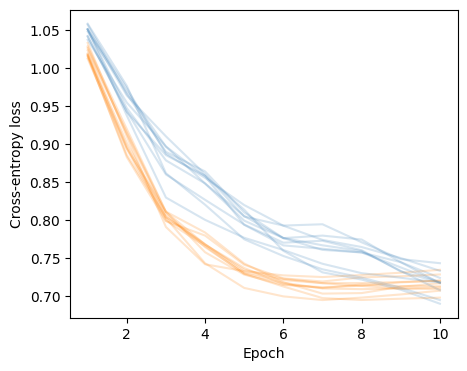

------------------------------ 
Training set:
Average log-likelihood = -506.6 (3.9)
Average accuracy       = 73.3% (0.6%)
Average F1 score       = 72.8% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -143.2 (2.0)
Average accuracy       = 68.8% (0.9%)
Average F1 score       = 68.3% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -322.5 (3.4)
Average accuracy       = 73.6% (0.8%)
Average F1 score       = 73.1% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.900 (0.071)
Weak regularity   = 0.907 (0.069)
------------------------------ 
Validation set:
Strong regularity = 0.890 (0.073)
Weak regularity   = 0.894 (0.071)
------------------------------ 
Test set:
Strong regularity = 0.903 (0.065)
Weak regularity   = 0.912 (0.062)
------------------------------


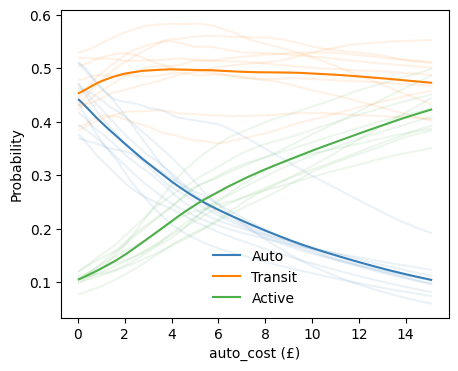

------------------------------ 
Model comparison:


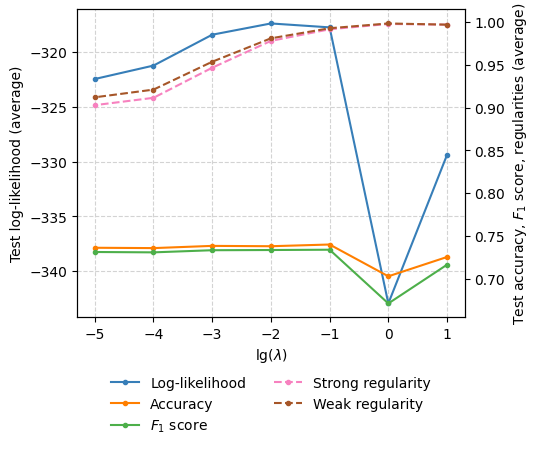

In [52]:
# With sum
result(DNN, 10, 'UGR', [10**i for i in range(1, -6, -1)])

### LGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -560.6 | acc = 71.1% | F1 = 70.2%
Validation set: LL = -144.3 | acc = 67.5% | F1 = 65.9%
Test set:       LL = -350.1 | acc = 69.0% | F1 = 67.7%
Model 2 
Training set:   LL = -557.6 | acc = 71.4% | F1 = 70.3%
Validation set: LL = -141.6 | acc = 68.0% | F1 = 66.8%
Test set:       LL = -341.0 | acc = 71.6% | F1 = 70.4%
Model 3 
Training set:   LL = -568.8 | acc = 71.0% | F1 = 69.6%
Validation set: LL = -143.7 | acc = 68.0% | F1 = 66.2%
Test set:       LL = -345.2 | acc = 70.4% | F1 = 68.3%
Model 4 
Training set:   LL = -530.8 | acc = 72.1% | F1 = 70.7%
Validation set: LL = -140.4 | acc = 68.0% | F1 = 66.9%
Test set:       LL = -335.9 | acc = 71.0% | F1 = 69.5%
Model 5 
Training set:   LL = -567.2 | acc = 70.5% | F1 = 69.6%
Validation set: LL = -147.2 | acc = 66.5% | F1 = 65.0%
Test set:       LL = -339.2 | acc = 70.4% | F1 = 69.0%
Model 6 
Training set:   LL = -563.3 | acc = 68.8% | F1 = 66.6%
Validation set: LL = -

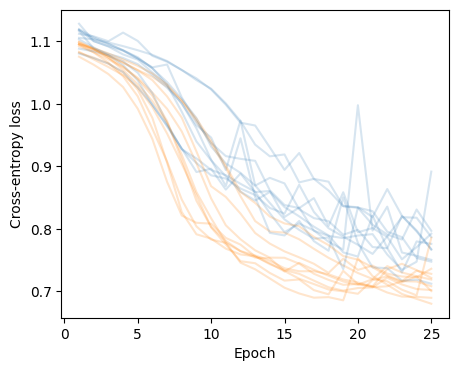

------------------------------ 
Training set:
Average log-likelihood = -562.4 (32.6)
Average accuracy       = 70.3% (1.8%)
Average F1 score       = 68.4% (3.5%)
------------------------------ 
Validation set:
Average log-likelihood = -143.4 (5.6)
Average accuracy       = 67.7% (1.3%)
Average F1 score       = 65.5% (2.6%)
------------------------------ 
Test set:
Average log-likelihood = -346.4 (24.0)
Average accuracy       = 69.9% (2.0%)
Average F1 score       = 67.6% (3.8%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


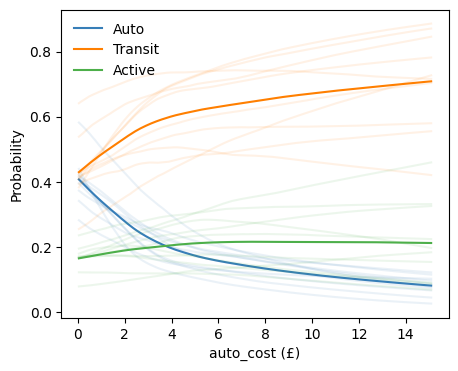

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -570.1 | acc = 66.8% | F1 = 63.9%
Validation set: LL = -143.3 | acc = 66.0% | F1 = 62.2%
Test set:       LL = -338.4 | acc = 69.8% | F1 = 66.5%
Model 2 
Training set:   LL = -560.3 | acc = 69.5% | F1 = 67.7%
Validation set: LL = -137.3 | acc = 68.0% | F1 = 65.7%
Test set:       LL = -339.7 | acc = 71.6% | F1 = 69.6%
Model 3 
Training set:   LL = -569.5 | acc = 68.0% | F1 = 66.5%
Validation set: LL = -141.9 | acc = 69.5% | F1 = 67.4%
Test set:       LL = -337.8 | acc = 72.6% | F1 = 71.1%
Model 4 
Training set:   LL = -580.3 | acc = 66.5% | F1 = 61.2%
Validation set: LL = -146.1 | acc = 63.5% | F1 = 57.5%
Test set:       LL = -352.8 | acc = 67.6% | F1 = 61.2%
Model 5 
Training set:   LL = -550.1 | acc = 70.0% | F1 = 68.6%
Validation set: LL = -139.3 | acc = 67.5% | F1 = 65.2%
Test set:       LL = -321.9 | acc = 73.2% | F1 = 71.7%
Model 6 
Training set:   LL = -547.8 | acc = 72.0% | F1 = 71.3%
Validation set: LL = -1

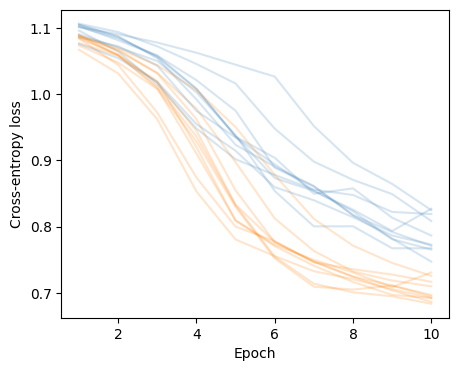

------------------------------ 
Training set:
Average log-likelihood = -560.6 (13.3)
Average accuracy       = 69.3% (2.0%)
Average F1 score       = 67.3% (3.2%)
------------------------------ 
Validation set:
Average log-likelihood = -140.5 (3.2)
Average accuracy       = 68.0% (1.9%)
Average F1 score       = 65.3% (3.1%)
------------------------------ 
Test set:
Average log-likelihood = -335.2 (11.3)
Average accuracy       = 71.7% (2.1%)
Average F1 score       = 69.4% (3.8%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 0.999 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.007)
Weak regularity   = 0.997 (0.006)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.008)
Weak regularity   = 0.998 (0.006)
------------------------------


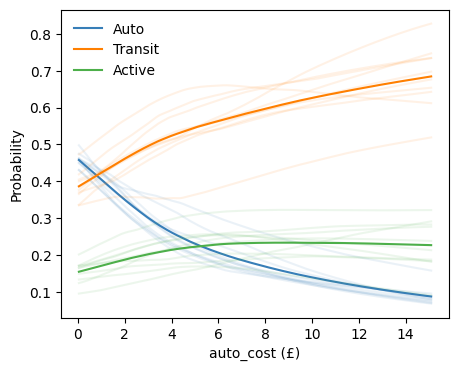

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -522.3 | acc = 72.9% | F1 = 72.2%
Validation set: LL = -137.3 | acc = 69.0% | F1 = 68.3%
Test set:       LL = -322.7 | acc = 72.2% | F1 = 71.4%
Model 2 
Training set:   LL = -512.2 | acc = 73.6% | F1 = 73.0%
Validation set: LL = -136.7 | acc = 70.0% | F1 = 69.6%
Test set:       LL = -323.1 | acc = 73.4% | F1 = 72.8%
Model 3 
Training set:   LL = -519.8 | acc = 72.9% | F1 = 72.5%
Validation set: LL = -139.5 | acc = 68.0% | F1 = 67.7%
Test set:       LL = -315.6 | acc = 72.8% | F1 = 72.6%
Model 4 
Training set:   LL = -515.3 | acc = 72.2% | F1 = 70.9%
Validation set: LL = -141.0 | acc = 67.5% | F1 = 66.4%
Test set:       LL = -322.0 | acc = 73.4% | F1 = 72.4%
Model 5 
Training set:   LL = -508.7 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -140.0 | acc = 70.0% | F1 = 69.6%
Test set:       LL = -316.6 | acc = 73.8% | F1 = 73.3%
Model 6 
Training set:   LL = -518.6 | acc = 71.9% | F1 = 69.9%
Validation set: LL = 

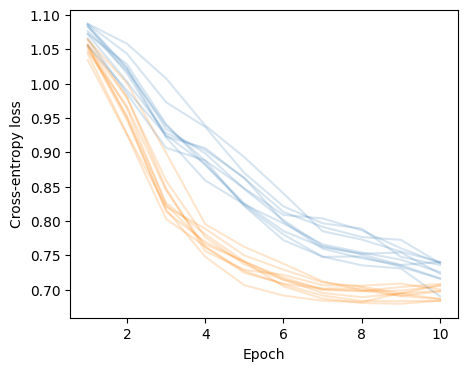

------------------------------ 
Training set:
Average log-likelihood = -513.5 (6.6)
Average accuracy       = 73.1% (0.7%)
Average F1 score       = 72.3% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -139.1 (1.9)
Average accuracy       = 69.2% (0.9%)
Average F1 score       = 68.4% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -320.1 (4.0)
Average accuracy       = 73.2% (0.7%)
Average F1 score       = 72.5% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.981 (0.017)
Weak regularity   = 0.985 (0.014)
------------------------------ 
Validation set:
Strong regularity = 0.976 (0.022)
Weak regularity   = 0.981 (0.018)
------------------------------ 
Test set:
Strong regularity = 0.979 (0.016)
Weak regularity   = 0.983 (0.014)
------------------------------


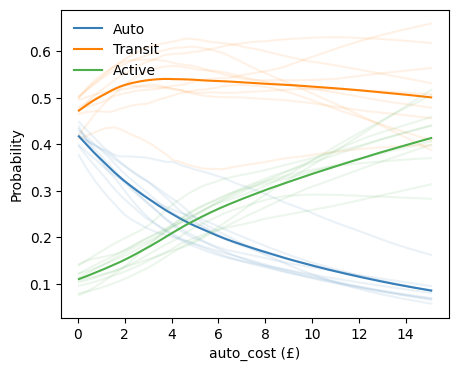

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -512.1 | acc = 72.9% | F1 = 72.4%
Validation set: LL = -139.0 | acc = 69.5% | F1 = 69.1%
Test set:       LL = -320.5 | acc = 72.4% | F1 = 71.8%
Model 2 
Training set:   LL = -497.9 | acc = 74.4% | F1 = 73.8%
Validation set: LL = -140.5 | acc = 69.5% | F1 = 69.1%
Test set:       LL = -322.7 | acc = 74.2% | F1 = 73.7%
Model 3 
Training set:   LL = -507.7 | acc = 73.4% | F1 = 72.7%
Validation set: LL = -139.3 | acc = 70.0% | F1 = 69.4%
Test set:       LL = -318.8 | acc = 73.2% | F1 = 72.5%
Model 4 
Training set:   LL = -507.0 | acc = 73.0% | F1 = 72.3%
Validation set: LL = -143.0 | acc = 68.5% | F1 = 67.8%
Test set:       LL = -321.2 | acc = 73.0% | F1 = 72.4%
Model 5 
Training set:   LL = -497.2 | acc = 73.6% | F1 = 73.0%
Validation set: LL = -142.2 | acc = 70.0% | F1 = 69.2%
Test set:       LL = -313.2 | acc = 73.2% | F1 = 72.6%
Model 6 
Training set:   LL = -506.7 | acc = 73.2% | F1 = 72.6%
Validation set: LL =

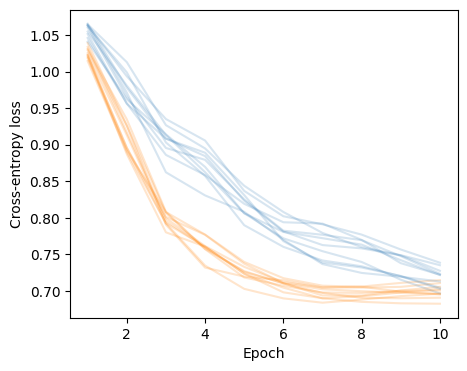

------------------------------ 
Training set:
Average log-likelihood = -504.7 (5.7)
Average accuracy       = 73.5% (0.5%)
Average F1 score       = 72.9% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -139.9 (1.8)
Average accuracy       = 69.6% (0.7%)
Average F1 score       = 69.0% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -319.4 (3.6)
Average accuracy       = 73.3% (0.7%)
Average F1 score       = 72.7% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.026)
Weak regularity   = 0.956 (0.023)
------------------------------ 
Validation set:
Strong regularity = 0.938 (0.031)
Weak regularity   = 0.947 (0.027)
------------------------------ 
Test set:
Strong regularity = 0.948 (0.025)
Weak regularity   = 0.957 (0.023)
------------------------------


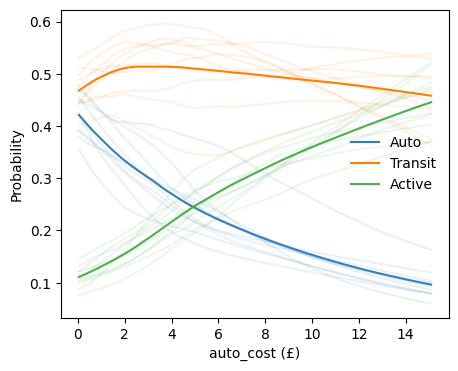

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -510.3 | acc = 72.9% | F1 = 72.4%
Validation set: LL = -140.8 | acc = 69.0% | F1 = 68.4%
Test set:       LL = -321.2 | acc = 74.0% | F1 = 73.6%
Model 2 
Training set:   LL = -501.7 | acc = 74.0% | F1 = 73.5%
Validation set: LL = -143.8 | acc = 70.0% | F1 = 69.5%
Test set:       LL = -323.0 | acc = 73.4% | F1 = 72.9%
Model 3 
Training set:   LL = -510.6 | acc = 73.2% | F1 = 72.6%
Validation set: LL = -140.0 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -323.1 | acc = 73.2% | F1 = 72.4%
Model 4 
Training set:   LL = -506.3 | acc = 73.2% | F1 = 72.6%
Validation set: LL = -143.3 | acc = 67.5% | F1 = 66.7%
Test set:       LL = -323.4 | acc = 73.8% | F1 = 73.3%
Model 5 
Training set:   LL = -502.4 | acc = 73.1% | F1 = 72.5%
Validation set: LL = -145.0 | acc = 68.0% | F1 = 67.2%
Test set:       LL = -314.4 | acc = 73.8% | F1 = 73.2%
Model 6 
Training set:   LL = -508.5 | acc = 73.2% | F1 = 72.5%
Validation set: LL 

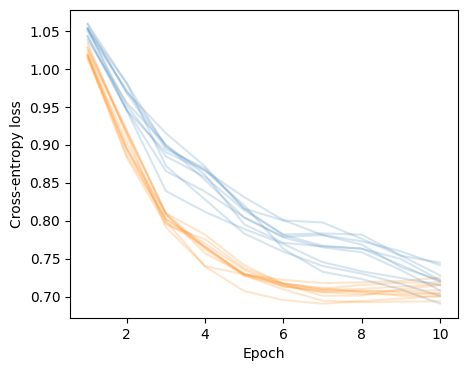

------------------------------ 
Training set:
Average log-likelihood = -506.0 (4.0)
Average accuracy       = 73.3% (0.5%)
Average F1 score       = 72.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -141.7 (1.9)
Average accuracy       = 68.8% (0.9%)
Average F1 score       = 68.1% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -320.6 (3.4)
Average accuracy       = 73.7% (0.7%)
Average F1 score       = 73.1% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.912 (0.061)
Weak regularity   = 0.918 (0.059)
------------------------------ 
Validation set:
Strong regularity = 0.898 (0.068)
Weak regularity   = 0.905 (0.067)
------------------------------ 
Test set:
Strong regularity = 0.914 (0.060)
Weak regularity   = 0.923 (0.058)
------------------------------


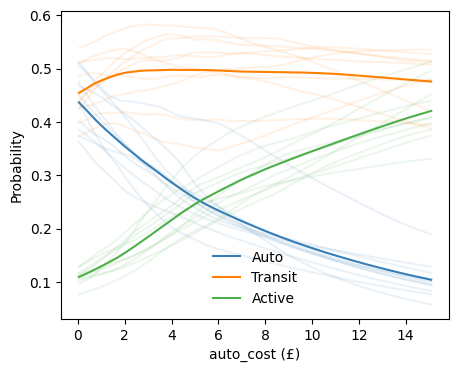

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -509.3 | acc = 73.0% | F1 = 72.6%
Validation set: LL = -142.6 | acc = 68.5% | F1 = 68.0%
Test set:       LL = -323.3 | acc = 74.2% | F1 = 73.8%
Model 2 
Training set:   LL = -500.9 | acc = 73.9% | F1 = 73.5%
Validation set: LL = -145.7 | acc = 69.5% | F1 = 69.2%
Test set:       LL = -325.0 | acc = 72.6% | F1 = 72.3%
Model 3 
Training set:   LL = -511.9 | acc = 73.0% | F1 = 72.3%
Validation set: LL = -141.8 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -325.4 | acc = 73.4% | F1 = 72.7%
Model 4 
Training set:   LL = -508.1 | acc = 72.5% | F1 = 71.9%
Validation set: LL = -143.8 | acc = 69.0% | F1 = 68.3%
Test set:       LL = -324.5 | acc = 74.8% | F1 = 74.3%
Model 5 
Training set:   LL = -504.0 | acc = 73.1% | F1 = 72.6%
Validation set: LL = -146.6 | acc = 68.0% | F1 = 67.1%
Test set:       LL = -316.3 | acc = 74.0% | F1 = 73.5%
Model 6 
Training set:   LL = -509.2 | acc = 73.5% | F1 = 72.9%
Validation set: LL

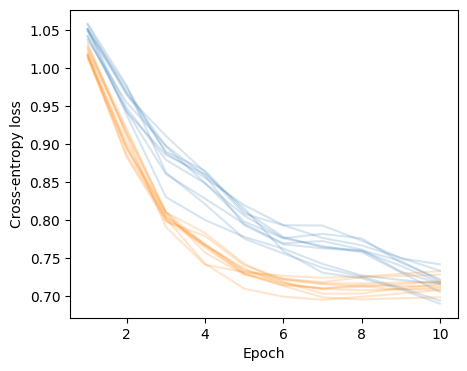

------------------------------ 
Training set:
Average log-likelihood = -506.4 (4.0)
Average accuracy       = 73.2% (0.6%)
Average F1 score       = 72.7% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -143.1 (1.9)
Average accuracy       = 68.9% (0.7%)
Average F1 score       = 68.3% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -322.3 (3.5)
Average accuracy       = 73.6% (0.7%)
Average F1 score       = 73.1% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.900 (0.070)
Weak regularity   = 0.909 (0.067)
------------------------------ 
Validation set:
Strong regularity = 0.890 (0.073)
Weak regularity   = 0.898 (0.071)
------------------------------ 
Test set:
Strong regularity = 0.903 (0.065)
Weak regularity   = 0.913 (0.063)
------------------------------


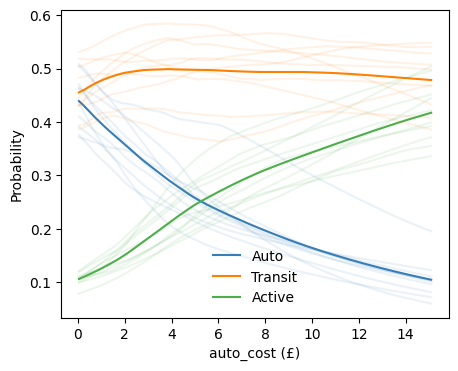

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -509.0 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -142.7 | acc = 69.0% | F1 = 68.5%
Test set:       LL = -323.4 | acc = 74.4% | F1 = 74.1%
Model 2 
Training set:   LL = -501.3 | acc = 73.2% | F1 = 72.9%
Validation set: LL = -146.1 | acc = 69.0% | F1 = 68.8%
Test set:       LL = -325.7 | acc = 72.8% | F1 = 72.6%
Model 3 
Training set:   LL = -511.6 | acc = 72.5% | F1 = 71.8%
Validation set: LL = -141.7 | acc = 69.0% | F1 = 68.1%
Test set:       LL = -325.5 | acc = 73.4% | F1 = 72.8%
Model 4 
Training set:   LL = -508.9 | acc = 72.5% | F1 = 71.9%
Validation set: LL = -144.0 | acc = 69.0% | F1 = 68.0%
Test set:       LL = -324.9 | acc = 74.6% | F1 = 74.1%
Model 5 
Training set:   LL = -503.9 | acc = 73.5% | F1 = 73.0%
Validation set: LL = -146.8 | acc = 68.0% | F1 = 67.3%
Test set:       LL = -317.0 | acc = 73.4% | F1 = 72.9%
Model 6 
Training set:   LL = -509.5 | acc = 73.5% | F1 = 72.9%
Validation set: LL 

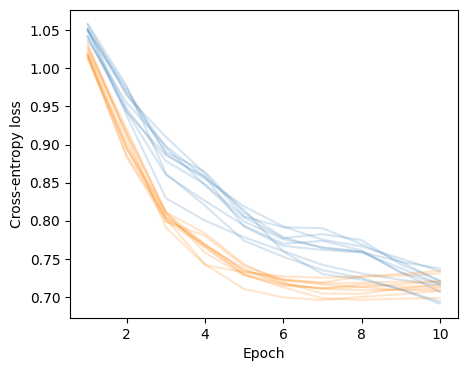

------------------------------ 
Training set:
Average log-likelihood = -506.4 (3.8)
Average accuracy       = 73.1% (0.6%)
Average F1 score       = 72.6% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -143.2 (2.0)
Average accuracy       = 68.8% (0.7%)
Average F1 score       = 68.2% (0.8%)
------------------------------ 
Test set:
Average log-likelihood = -322.7 (3.5)
Average accuracy       = 73.6% (0.8%)
Average F1 score       = 73.1% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.899 (0.071)
Weak regularity   = 0.908 (0.068)
------------------------------ 
Validation set:
Strong regularity = 0.886 (0.071)
Weak regularity   = 0.897 (0.068)
------------------------------ 
Test set:
Strong regularity = 0.904 (0.066)
Weak regularity   = 0.913 (0.065)
------------------------------


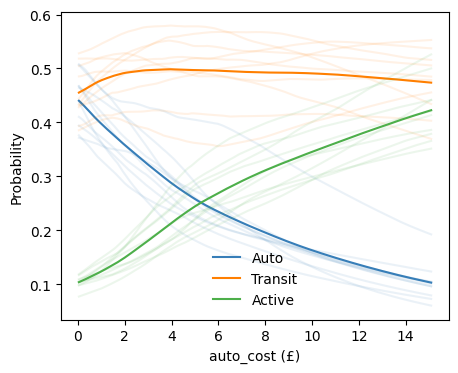

------------------------------ 
Model comparison:


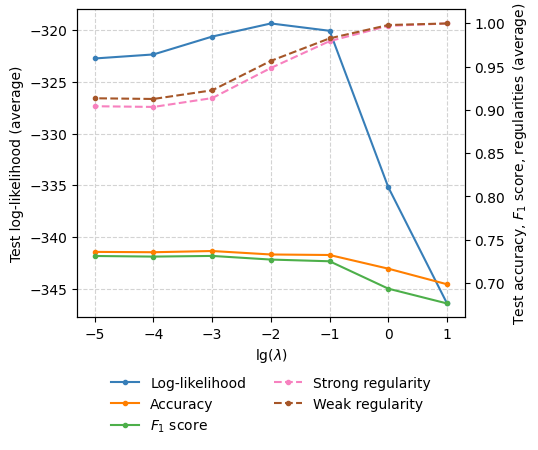

In [53]:
# With sum
result(DNN, 10, 'LGR', [10**i for i in range(1, -6, -1)])

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [54]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(7, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :7])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 7:9], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 9:11], dim=1)
        V3 = betas[:, 6] * x[:, 11]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.5 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.3 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 71.8% | F1 = 70.4%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.6% | F1 = 71.3%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL = -1

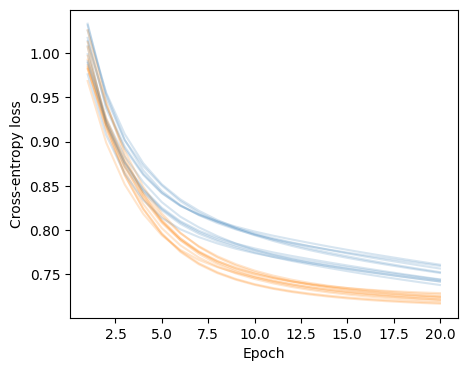

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.023)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.027)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


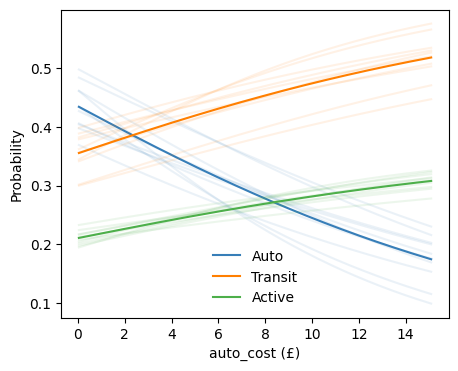

In [55]:
result(TasteNet, 20, 'none')

### PGR

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -630.7 | acc = 65.2% | F1 = 61.2%
Validation set: LL = -155.9 | acc = 66.0% | F1 = 61.8%
Test set:       LL = -378.7 | acc = 67.4% | F1 = 62.5%
Model 2 
Training set:   LL = -613.2 | acc = 65.4% | F1 = 61.1%
Validation set: LL = -152.9 | acc = 67.5% | F1 = 63.7%
Test set:       LL = -370.4 | acc = 69.2% | F1 = 64.0%
Model 3 
Training set:   LL = -665.6 | acc = 63.1% | F1 = 56.6%
Validation set: LL = -162.6 | acc = 65.5% | F1 = 59.9%
Test set:       LL = -395.6 | acc = 67.2% | F1 = 59.8%
Model 4 
Training set:   LL = -653.9 | acc = 64.5% | F1 = 59.6%
Validation set: LL = -159.4 | acc = 67.5% | F1 = 63.8%
Test set:       LL = -391.8 | acc = 68.0% | F1 = 62.5%
Model 5 
Training set:   LL = -627.5 | acc = 64.4% | F1 = 59.0%
Validation set: LL = -155.7 | acc = 65.5% | F1 = 60.5%
Test set:       LL = -373.1 | acc = 67.6% | F1 = 61.4%
Model 6 
Training set:   LL = -658.8 | acc = 64.1% | F1 = 58.7%
Validation set: LL = -1

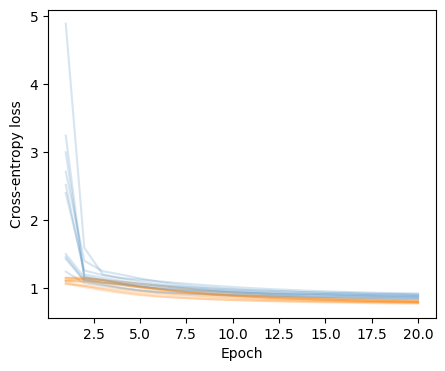

------------------------------ 
Training set:
Average log-likelihood = -645.0 (19.4)
Average accuracy       = 64.3% (0.7%)
Average F1 score       = 59.3% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -158.0 (2.8)
Average accuracy       = 65.8% (1.4%)
Average F1 score       = 61.1% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -385.6 (13.5)
Average accuracy       = 67.7% (0.8%)
Average F1 score       = 61.7% (1.3%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


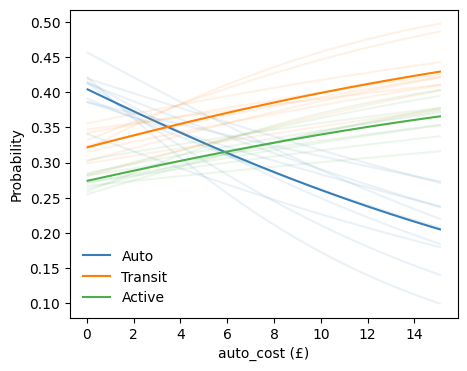

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -572.3 | acc = 68.1% | F1 = 66.1%
Validation set: LL = -144.9 | acc = 71.0% | F1 = 68.5%
Test set:       LL = -347.1 | acc = 71.4% | F1 = 69.2%
Model 2 
Training set:   LL = -566.0 | acc = 69.2% | F1 = 67.0%
Validation set: LL = -144.7 | acc = 69.5% | F1 = 66.8%
Test set:       LL = -344.6 | acc = 73.0% | F1 = 70.9%
Model 3 
Training set:   LL = -588.0 | acc = 68.2% | F1 = 65.9%
Validation set: LL = -146.6 | acc = 69.5% | F1 = 67.4%
Test set:       LL = -352.7 | acc = 72.4% | F1 = 70.4%
Model 4 
Training set:   LL = -582.6 | acc = 66.8% | F1 = 64.1%
Validation set: LL = -147.9 | acc = 67.0% | F1 = 64.6%
Test set:       LL = -351.2 | acc = 70.2% | F1 = 67.1%
Model 5 
Training set:   LL = -576.4 | acc = 68.4% | F1 = 66.2%
Validation set: LL = -145.5 | acc = 68.0% | F1 = 65.1%
Test set:       LL = -347.5 | acc = 71.8% | F1 = 69.5%
Model 6 
Training set:   LL = -585.6 | acc = 67.5% | F1 = 64.4%
Validation set: LL = 

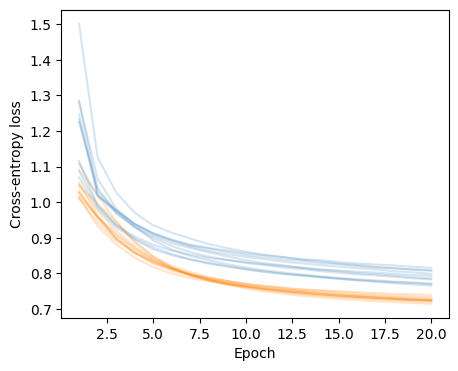

------------------------------ 
Training set:
Average log-likelihood = -577.7 (8.1)
Average accuracy       = 68.0% (0.9%)
Average F1 score       = 65.6% (1.3%)
------------------------------ 
Validation set:
Average log-likelihood = -145.1 (1.3)
Average accuracy       = 68.6% (1.2%)
Average F1 score       = 65.9% (1.3%)
------------------------------ 
Test set:
Average log-likelihood = -348.4 (5.1)
Average accuracy       = 71.3% (1.6%)
Average F1 score       = 68.6% (2.6%)
------------------------------ 
Training set:
Strong regularity = 0.994 (0.011)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.014)
Weak regularity   = 1.000 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.012)
Weak regularity   = 0.999 (0.004)
------------------------------


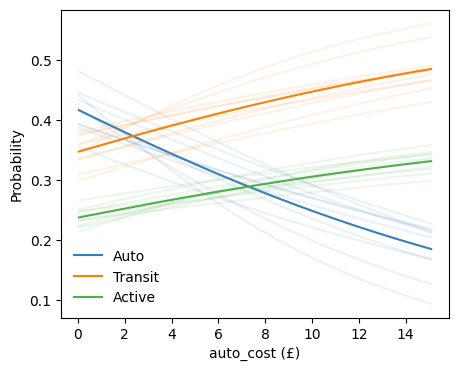

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -550.7 | acc = 70.4% | F1 = 69.2%
Validation set: LL = -142.3 | acc = 72.5% | F1 = 70.5%
Test set:       LL = -339.0 | acc = 72.0% | F1 = 70.7%
Model 2 
Training set:   LL = -548.1 | acc = 71.2% | F1 = 69.9%
Validation set: LL = -142.4 | acc = 71.0% | F1 = 69.1%
Test set:       LL = -338.3 | acc = 73.8% | F1 = 72.4%
Model 3 
Training set:   LL = -556.8 | acc = 70.1% | F1 = 68.8%
Validation set: LL = -141.5 | acc = 70.5% | F1 = 68.4%
Test set:       LL = -339.9 | acc = 72.8% | F1 = 71.5%
Model 4 
Training set:   LL = -554.2 | acc = 70.1% | F1 = 68.9%
Validation set: LL = -143.2 | acc = 70.5% | F1 = 68.4%
Test set:       LL = -342.2 | acc = 73.8% | F1 = 72.4%
Model 5 
Training set:   LL = -554.5 | acc = 69.2% | F1 = 67.6%
Validation set: LL = -141.4 | acc = 70.0% | F1 = 67.6%
Test set:       LL = -340.6 | acc = 73.4% | F1 = 72.0%
Model 6 
Training set:   LL = -558.4 | acc = 71.4% | F1 = 70.1%
Validation set: LL =

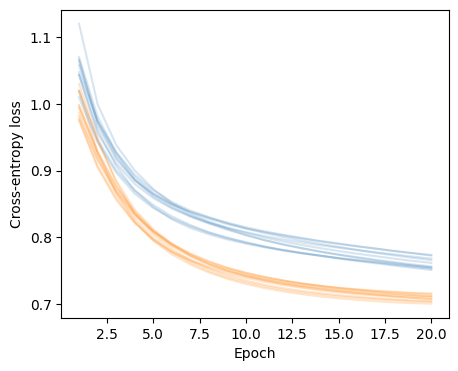

------------------------------ 
Training set:
Average log-likelihood = -553.0 (3.4)
Average accuracy       = 70.3% (0.6%)
Average F1 score       = 68.9% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -141.7 (1.0)
Average accuracy       = 70.5% (0.9%)
Average F1 score       = 68.4% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -339.7 (2.0)
Average accuracy       = 73.4% (0.6%)
Average F1 score       = 72.0% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.968 (0.013)
Weak regularity   = 0.988 (0.011)
------------------------------ 
Validation set:
Strong regularity = 0.970 (0.015)
Weak regularity   = 0.984 (0.012)
------------------------------ 
Test set:
Strong regularity = 0.964 (0.013)
Weak regularity   = 0.984 (0.012)
------------------------------


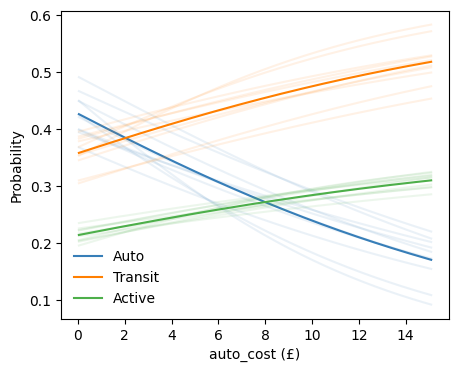

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -546.0 | acc = 69.2% | F1 = 67.9%
Validation set: LL = -143.7 | acc = 72.0% | F1 = 70.1%
Test set:       LL = -339.5 | acc = 72.8% | F1 = 71.6%
Model 2 
Training set:   LL = -543.0 | acc = 70.6% | F1 = 69.2%
Validation set: LL = -144.0 | acc = 71.0% | F1 = 68.8%
Test set:       LL = -342.1 | acc = 73.0% | F1 = 71.5%
Model 3 
Training set:   LL = -549.7 | acc = 70.5% | F1 = 69.3%
Validation set: LL = -142.4 | acc = 69.5% | F1 = 67.2%
Test set:       LL = -341.3 | acc = 74.0% | F1 = 72.7%
Model 4 
Training set:   LL = -547.3 | acc = 70.9% | F1 = 69.6%
Validation set: LL = -144.1 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -345.5 | acc = 73.2% | F1 = 71.7%
Model 5 
Training set:   LL = -547.8 | acc = 69.2% | F1 = 67.8%
Validation set: LL = -142.9 | acc = 69.0% | F1 = 66.4%
Test set:       LL = -344.7 | acc = 73.4% | F1 = 72.0%
Model 6 
Training set:   LL = -553.5 | acc = 70.5% | F1 = 69.1%
Validation set: LL 

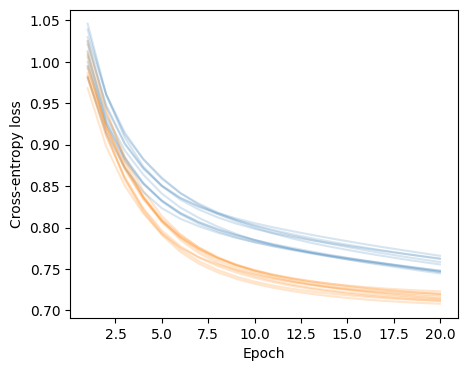

------------------------------ 
Training set:
Average log-likelihood = -547.1 (3.3)
Average accuracy       = 70.3% (0.6%)
Average F1 score       = 69.0% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -143.1 (0.9)
Average accuracy       = 70.3% (1.0%)
Average F1 score       = 68.2% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -342.4 (2.3)
Average accuracy       = 73.1% (0.5%)
Average F1 score       = 71.7% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.022)
Weak regularity   = 0.952 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.025)
Weak regularity   = 0.952 (0.022)
------------------------------ 
Test set:
Strong regularity = 0.940 (0.021)
Weak regularity   = 0.945 (0.020)
------------------------------


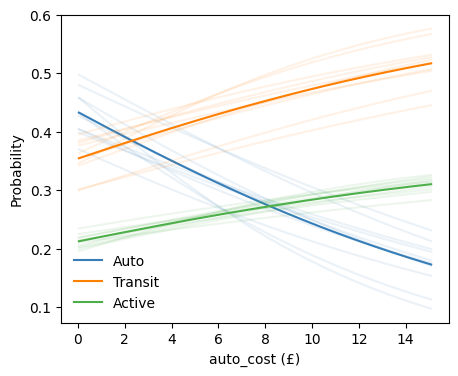

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -546.4 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.6 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.1 | acc = 72.4% | F1 = 71.1%
Model 2 
Training set:   LL = -543.6 | acc = 70.5% | F1 = 69.1%
Validation set: LL = -144.8 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -343.9 | acc = 73.4% | F1 = 72.1%
Model 3 
Training set:   LL = -550.4 | acc = 70.5% | F1 = 69.1%
Validation set: LL = -143.7 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -343.8 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -547.8 | acc = 71.1% | F1 = 70.0%
Validation set: LL = -145.2 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.5 | acc = 72.2% | F1 = 70.9%
Model 5 
Training set:   LL = -548.3 | acc = 69.9% | F1 = 68.4%
Validation set: LL = -144.1 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.5 | acc = 72.6% | F1 = 71.2%
Model 6 
Training set:   LL = -554.2 | acc = 70.2% | F1 = 68.9%
Validation set: LL

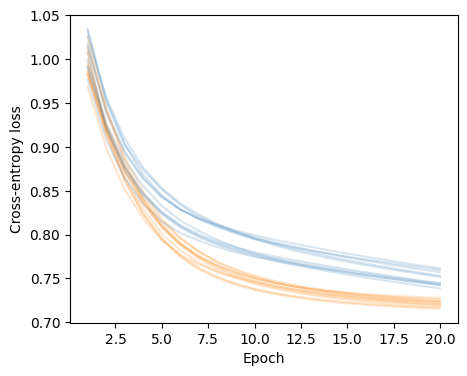

------------------------------ 
Training set:
Average log-likelihood = -547.8 (3.4)
Average accuracy       = 70.5% (0.4%)
Average F1 score       = 69.1% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -144.3 (0.8)
Average accuracy       = 69.7% (1.0%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -344.7 (2.3)
Average accuracy       = 72.6% (0.5%)
Average F1 score       = 71.2% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.022)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.025)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.940 (0.022)
Weak regularity   = 0.943 (0.024)
------------------------------


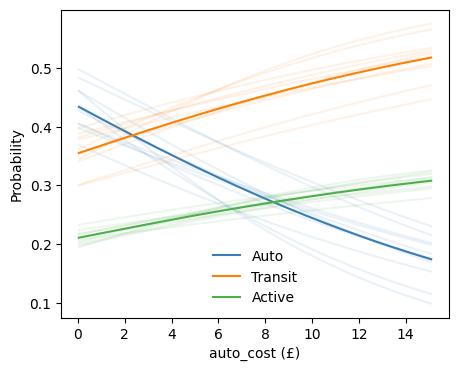

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.4 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.2 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 71.8% | F1 = 70.4%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.8% | F1 = 71.5%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

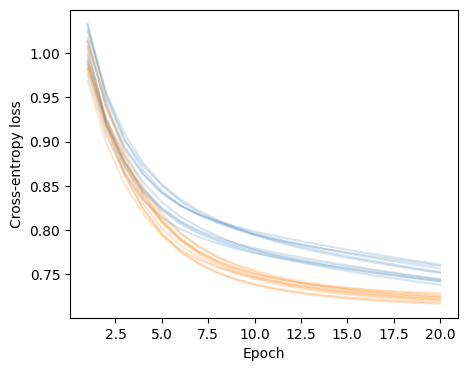

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.4%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.023)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.027)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


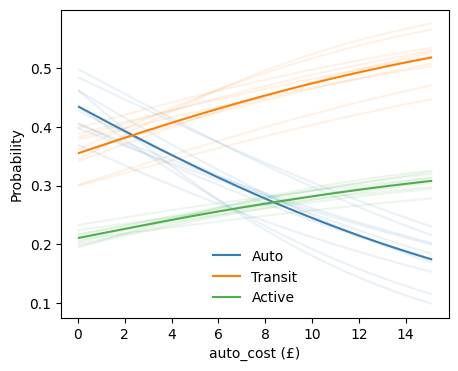

Penalty = 1e-06
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.5 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.3 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 71.8% | F1 = 70.4%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.6% | F1 = 71.3%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

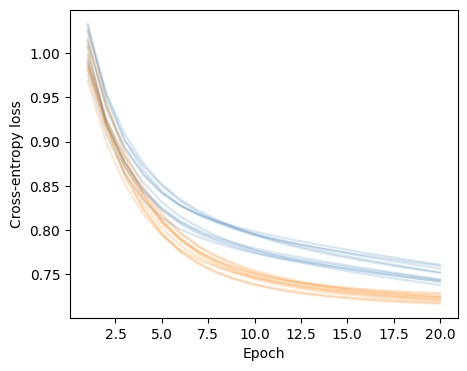

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.023)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.027)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


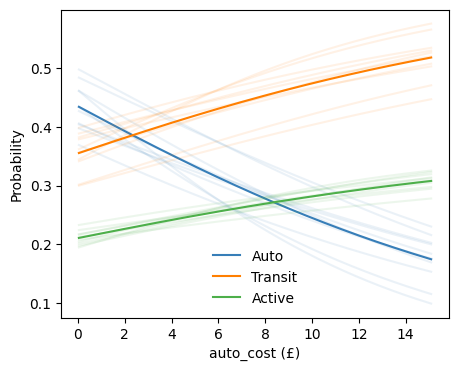

------------------------------ 
Model comparison:


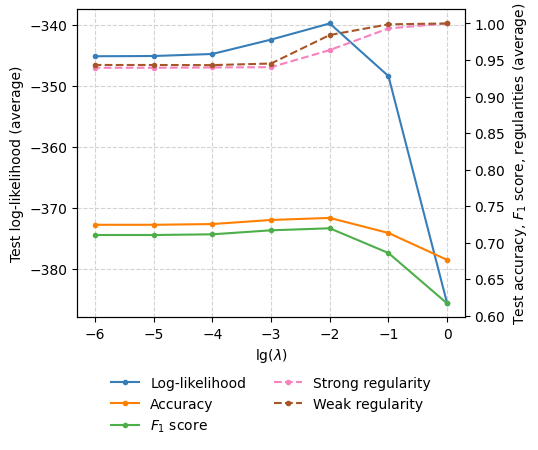

In [57]:
result(TasteNet, 20, 'PGR', [10**i for i in range(0, -7, -1)])

### UGR

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -661.8 | acc = 63.2% | F1 = 57.2%
Validation set: LL = -162.5 | acc = 64.0% | F1 = 59.0%
Test set:       LL = -396.0 | acc = 65.2% | F1 = 58.2%
Model 2 
Training set:   LL = -644.2 | acc = 64.4% | F1 = 58.9%
Validation set: LL = -158.4 | acc = 65.5% | F1 = 60.0%
Test set:       LL = -389.5 | acc = 67.0% | F1 = 59.7%
Model 3 
Training set:   LL = -684.5 | acc = 62.4% | F1 = 55.5%
Validation set: LL = -164.7 | acc = 66.5% | F1 = 59.6%
Test set:       LL = -402.4 | acc = 66.6% | F1 = 58.9%
Model 4 
Training set:   LL = -662.8 | acc = 61.4% | F1 = 55.3%
Validation set: LL = -160.0 | acc = 65.5% | F1 = 60.6%
Test set:       LL = -391.3 | acc = 66.4% | F1 = 59.2%
Model 5 
Training set:   LL = -658.5 | acc = 63.4% | F1 = 57.0%
Validation set: LL = -162.7 | acc = 65.5% | F1 = 60.3%
Test set:       LL = -391.4 | acc = 66.4% | F1 = 58.8%
Model 6 
Training set:   LL = -685.8 | acc = 62.6% | F1 = 56.4%
Validation set: LL = -1

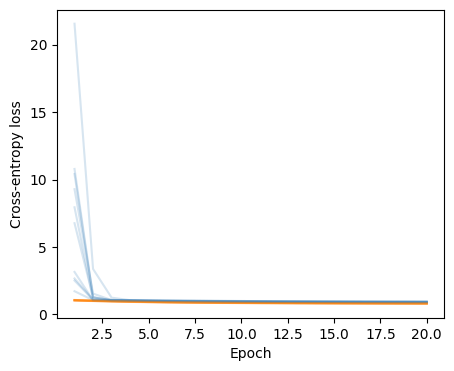

------------------------------ 
Training set:
Average log-likelihood = -668.5 (13.6)
Average accuracy       = 62.9% (0.8%)
Average F1 score       = 56.8% (1.0%)
------------------------------ 
Validation set:
Average log-likelihood = -162.0 (1.9)
Average accuracy       = 65.0% (0.7%)
Average F1 score       = 59.7% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -397.0 (8.0)
Average accuracy       = 66.2% (0.8%)
Average F1 score       = 58.9% (0.7%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


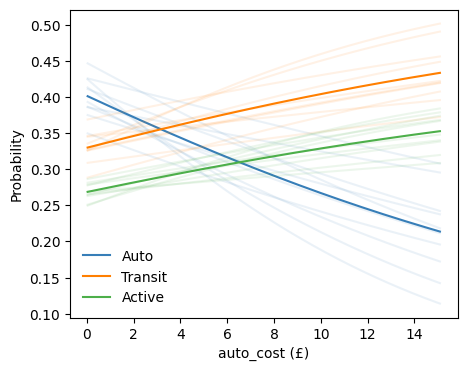

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -605.9 | acc = 66.4% | F1 = 63.0%
Validation set: LL = -151.0 | acc = 67.0% | F1 = 63.2%
Test set:       LL = -363.7 | acc = 68.6% | F1 = 64.8%
Model 2 
Training set:   LL = -595.1 | acc = 66.5% | F1 = 62.8%
Validation set: LL = -149.8 | acc = 68.5% | F1 = 64.7%
Test set:       LL = -359.4 | acc = 69.4% | F1 = 64.9%
Model 3 
Training set:   LL = -628.3 | acc = 64.5% | F1 = 59.5%
Validation set: LL = -153.9 | acc = 67.5% | F1 = 62.6%
Test set:       LL = -372.4 | acc = 67.4% | F1 = 60.8%
Model 4 
Training set:   LL = -618.1 | acc = 65.2% | F1 = 60.5%
Validation set: LL = -153.0 | acc = 65.5% | F1 = 61.4%
Test set:       LL = -368.2 | acc = 68.4% | F1 = 62.8%
Model 5 
Training set:   LL = -609.4 | acc = 66.4% | F1 = 62.4%
Validation set: LL = -152.6 | acc = 67.5% | F1 = 64.2%
Test set:       LL = -363.2 | acc = 69.8% | F1 = 65.3%
Model 6 
Training set:   LL = -626.1 | acc = 64.9% | F1 = 59.7%
Validation set: LL = 

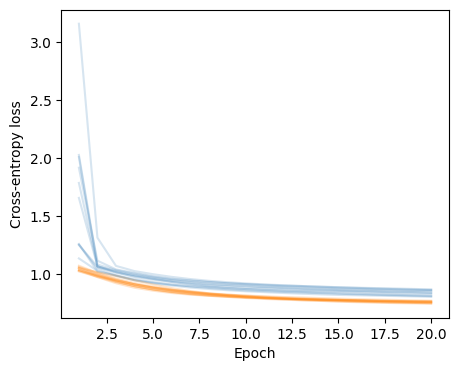

------------------------------ 
Training set:
Average log-likelihood = -612.9 (11.3)
Average accuracy       = 65.6% (0.8%)
Average F1 score       = 61.3% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -151.3 (1.6)
Average accuracy       = 66.6% (1.2%)
Average F1 score       = 62.4% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -365.5 (8.0)
Average accuracy       = 68.7% (1.0%)
Average F1 score       = 63.4% (1.9%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.007)
Weak regularity   = 1.000 (0.000)
------------------------------


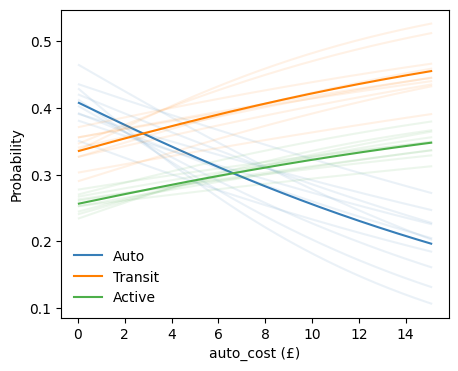

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -561.3 | acc = 69.5% | F1 = 67.9%
Validation set: LL = -143.2 | acc = 71.5% | F1 = 69.5%
Test set:       LL = -342.2 | acc = 72.4% | F1 = 70.9%
Model 2 
Training set:   LL = -558.0 | acc = 70.5% | F1 = 68.8%
Validation set: LL = -143.4 | acc = 71.5% | F1 = 69.5%
Test set:       LL = -341.4 | acc = 72.8% | F1 = 70.9%
Model 3 
Training set:   LL = -573.2 | acc = 68.8% | F1 = 66.9%
Validation set: LL = -144.1 | acc = 70.0% | F1 = 67.9%
Test set:       LL = -346.2 | acc = 73.0% | F1 = 71.5%
Model 4 
Training set:   LL = -569.5 | acc = 67.8% | F1 = 65.7%
Validation set: LL = -145.8 | acc = 69.0% | F1 = 66.8%
Test set:       LL = -346.1 | acc = 70.6% | F1 = 68.0%
Model 5 
Training set:   LL = -566.2 | acc = 68.9% | F1 = 66.9%
Validation set: LL = -143.4 | acc = 69.0% | F1 = 66.4%
Test set:       LL = -343.5 | acc = 72.2% | F1 = 70.2%
Model 6 
Training set:   LL = -572.4 | acc = 69.1% | F1 = 67.0%
Validation set: LL =

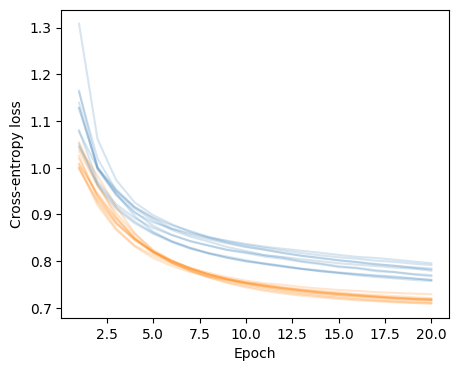

------------------------------ 
Training set:
Average log-likelihood = -565.9 (5.3)
Average accuracy       = 69.1% (0.7%)
Average F1 score       = 67.2% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -143.4 (1.1)
Average accuracy       = 69.8% (1.0%)
Average F1 score       = 67.6% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -343.5 (3.0)
Average accuracy       = 72.4% (0.9%)
Average F1 score       = 70.5% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


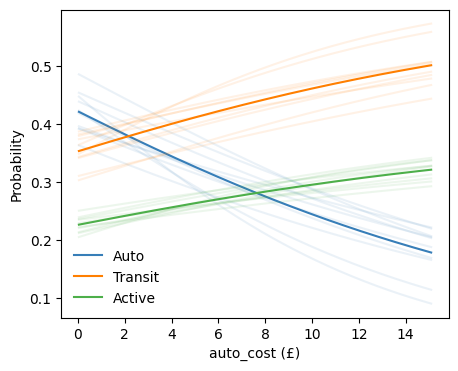

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -549.2 | acc = 70.5% | F1 = 69.3%
Validation set: LL = -142.2 | acc = 72.5% | F1 = 70.5%
Test set:       LL = -338.4 | acc = 72.2% | F1 = 70.9%
Model 2 
Training set:   LL = -546.6 | acc = 71.0% | F1 = 69.6%
Validation set: LL = -142.3 | acc = 71.5% | F1 = 69.5%
Test set:       LL = -338.8 | acc = 73.6% | F1 = 72.2%
Model 3 
Training set:   LL = -554.1 | acc = 70.6% | F1 = 69.4%
Validation set: LL = -141.1 | acc = 70.0% | F1 = 67.6%
Test set:       LL = -338.9 | acc = 73.0% | F1 = 71.7%
Model 4 
Training set:   LL = -552.0 | acc = 70.5% | F1 = 69.3%
Validation set: LL = -142.7 | acc = 70.0% | F1 = 67.5%
Test set:       LL = -342.0 | acc = 73.0% | F1 = 71.7%
Model 5 
Training set:   LL = -552.9 | acc = 69.2% | F1 = 67.7%
Validation set: LL = -141.1 | acc = 70.0% | F1 = 67.6%
Test set:       LL = -340.9 | acc = 73.6% | F1 = 72.2%
Model 6 
Training set:   LL = -556.3 | acc = 71.2% | F1 = 70.0%
Validation set: LL 

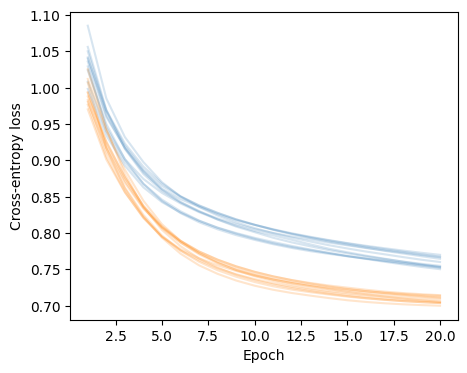

------------------------------ 
Training set:
Average log-likelihood = -551.0 (3.2)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.2% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -141.6 (0.9)
Average accuracy       = 70.7% (1.1%)
Average F1 score       = 68.6% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -339.6 (1.9)
Average accuracy       = 73.3% (0.4%)
Average F1 score       = 71.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.970 (0.013)
Weak regularity   = 0.987 (0.008)
------------------------------ 
Validation set:
Strong regularity = 0.973 (0.015)
Weak regularity   = 0.985 (0.009)
------------------------------ 
Test set:
Strong regularity = 0.966 (0.012)
Weak regularity   = 0.983 (0.009)
------------------------------


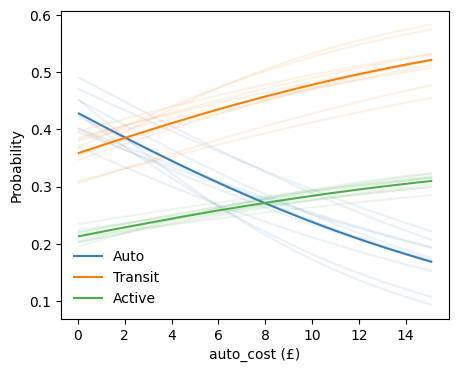

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -546.2 | acc = 69.9% | F1 = 68.6%
Validation set: LL = -144.0 | acc = 72.0% | F1 = 70.1%
Test set:       LL = -340.4 | acc = 72.8% | F1 = 71.5%
Model 2 
Training set:   LL = -543.2 | acc = 70.2% | F1 = 68.9%
Validation set: LL = -144.3 | acc = 71.0% | F1 = 68.8%
Test set:       LL = -342.5 | acc = 73.0% | F1 = 71.5%
Model 3 
Training set:   LL = -549.9 | acc = 70.5% | F1 = 69.2%
Validation set: LL = -142.8 | acc = 69.5% | F1 = 67.2%
Test set:       LL = -342.1 | acc = 73.6% | F1 = 72.2%
Model 4 
Training set:   LL = -547.4 | acc = 71.0% | F1 = 69.8%
Validation set: LL = -144.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -346.0 | acc = 72.6% | F1 = 71.2%
Model 5 
Training set:   LL = -548.1 | acc = 69.4% | F1 = 67.9%
Validation set: LL = -143.3 | acc = 69.0% | F1 = 66.4%
Test set:       LL = -345.8 | acc = 73.0% | F1 = 71.6%
Model 6 
Training set:   LL = -553.8 | acc = 70.0% | F1 = 68.6%
Validation set: LL

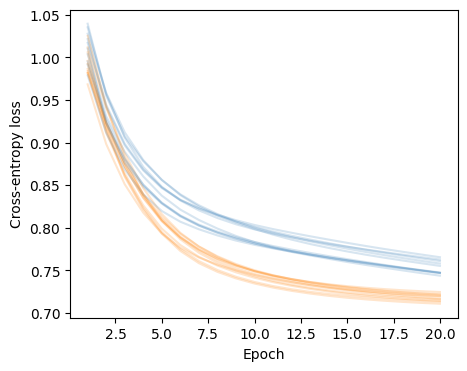

------------------------------ 
Training set:
Average log-likelihood = -547.4 (3.3)
Average accuracy       = 70.3% (0.5%)
Average F1 score       = 68.9% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -143.6 (0.8)
Average accuracy       = 70.0% (1.1%)
Average F1 score       = 67.9% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -343.1 (2.4)
Average accuracy       = 72.9% (0.5%)
Average F1 score       = 71.5% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.950 (0.019)
Weak regularity   = 0.953 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.952 (0.022)
Weak regularity   = 0.952 (0.022)
------------------------------ 
Test set:
Strong regularity = 0.944 (0.018)
Weak regularity   = 0.945 (0.020)
------------------------------


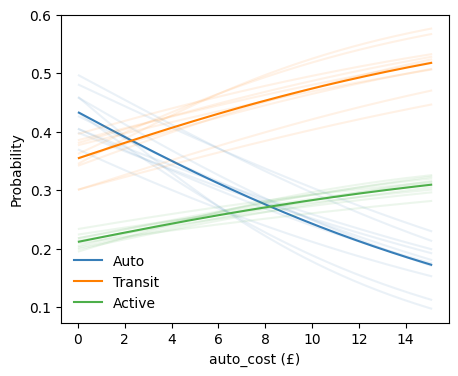

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -546.4 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.6 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.2 | acc = 72.4% | F1 = 71.1%
Model 2 
Training set:   LL = -543.6 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -144.9 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.0 | acc = 73.4% | F1 = 72.1%
Model 3 
Training set:   LL = -550.5 | acc = 70.4% | F1 = 69.0%
Validation set: LL = -143.8 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.0 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -547.9 | acc = 71.2% | F1 = 70.2%
Validation set: LL = -145.3 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.6 | acc = 72.0% | F1 = 70.6%
Model 5 
Training set:   LL = -548.4 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.1 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.6 | acc = 72.6% | F1 = 71.2%
Model 6 
Training set:   LL = -554.3 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

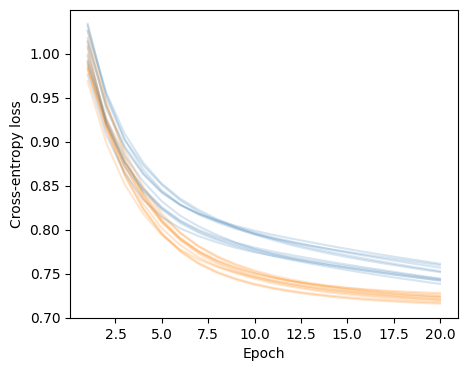

------------------------------ 
Training set:
Average log-likelihood = -547.9 (3.4)
Average accuracy       = 70.5% (0.4%)
Average F1 score       = 69.1% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -144.4 (0.8)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -344.9 (2.3)
Average accuracy       = 72.5% (0.5%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.022)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.025)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.940 (0.022)
Weak regularity   = 0.943 (0.024)
------------------------------


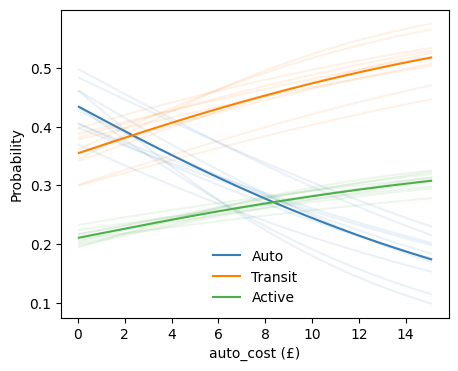

Penalty = 1e-06
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.4 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.2 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 71.8% | F1 = 70.4%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.6% | F1 = 71.3%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

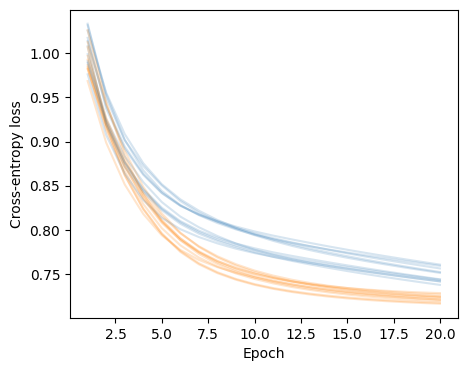

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 71.0% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.022)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.026)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


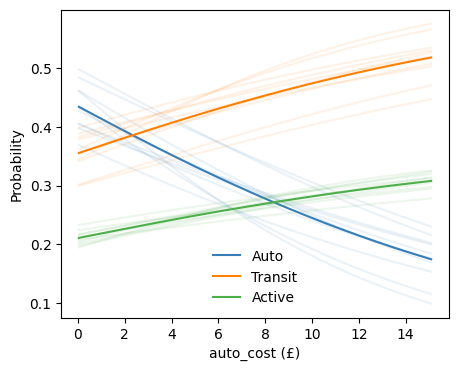

------------------------------ 
Model comparison:


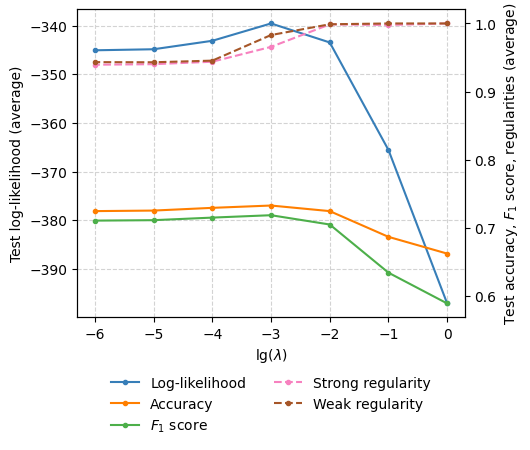

In [58]:
result(TasteNet, 20, 'UGR', [10**i for i in range(0, -7, -1)])

### LGR

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -632.1 | acc = 64.9% | F1 = 61.0%
Validation set: LL = -155.6 | acc = 65.5% | F1 = 60.9%
Test set:       LL = -381.1 | acc = 67.0% | F1 = 62.3%
Model 2 
Training set:   LL = -618.6 | acc = 65.4% | F1 = 61.1%
Validation set: LL = -153.3 | acc = 66.5% | F1 = 62.5%
Test set:       LL = -373.6 | acc = 69.2% | F1 = 64.2%
Model 3 
Training set:   LL = -665.8 | acc = 64.1% | F1 = 58.0%
Validation set: LL = -162.4 | acc = 65.5% | F1 = 60.0%
Test set:       LL = -397.8 | acc = 67.8% | F1 = 60.8%
Model 4 
Training set:   LL = -652.9 | acc = 62.7% | F1 = 58.0%
Validation set: LL = -159.5 | acc = 65.0% | F1 = 60.6%
Test set:       LL = -389.3 | acc = 66.6% | F1 = 60.7%
Model 5 
Training set:   LL = -629.8 | acc = 64.8% | F1 = 59.1%
Validation set: LL = -156.4 | acc = 65.5% | F1 = 60.5%
Test set:       LL = -373.6 | acc = 67.4% | F1 = 61.3%
Model 6 
Training set:   LL = -673.1 | acc = 63.1% | F1 = 57.5%
Validation set: LL = -1

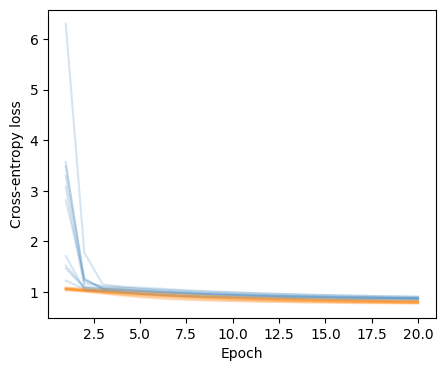

------------------------------ 
Training set:
Average log-likelihood = -650.7 (20.8)
Average accuracy       = 64.2% (0.7%)
Average F1 score       = 59.1% (1.3%)
------------------------------ 
Validation set:
Average log-likelihood = -159.2 (3.5)
Average accuracy       = 65.3% (0.7%)
Average F1 score       = 60.4% (1.3%)
------------------------------ 
Test set:
Average log-likelihood = -389.7 (14.7)
Average accuracy       = 67.2% (1.1%)
Average F1 score       = 61.2% (1.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 0.998 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 0.998 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.007)
Weak regularity   = 0.998 (0.007)
------------------------------


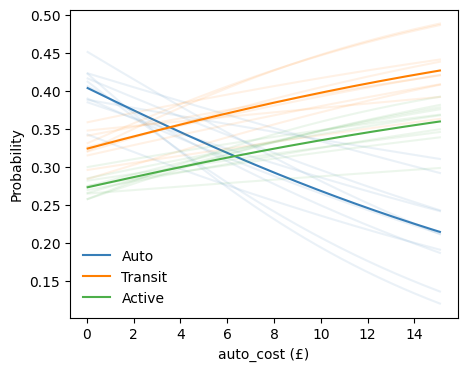

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -571.8 | acc = 68.8% | F1 = 66.9%
Validation set: LL = -144.9 | acc = 71.5% | F1 = 69.5%
Test set:       LL = -345.4 | acc = 72.0% | F1 = 70.0%
Model 2 
Training set:   LL = -569.2 | acc = 69.2% | F1 = 67.1%
Validation set: LL = -144.9 | acc = 69.5% | F1 = 66.8%
Test set:       LL = -345.5 | acc = 72.6% | F1 = 70.3%
Model 3 
Training set:   LL = -589.0 | acc = 68.2% | F1 = 66.0%
Validation set: LL = -146.1 | acc = 68.5% | F1 = 65.8%
Test set:       LL = -351.0 | acc = 73.4% | F1 = 71.7%
Model 4 
Training set:   LL = -586.8 | acc = 66.5% | F1 = 63.4%
Validation set: LL = -148.4 | acc = 67.0% | F1 = 64.3%
Test set:       LL = -352.4 | acc = 70.2% | F1 = 66.7%
Model 5 
Training set:   LL = -579.5 | acc = 68.2% | F1 = 66.1%
Validation set: LL = -146.1 | acc = 68.5% | F1 = 65.5%
Test set:       LL = -347.9 | acc = 72.6% | F1 = 70.5%
Model 6 
Training set:   LL = -590.0 | acc = 67.8% | F1 = 65.0%
Validation set: LL = 

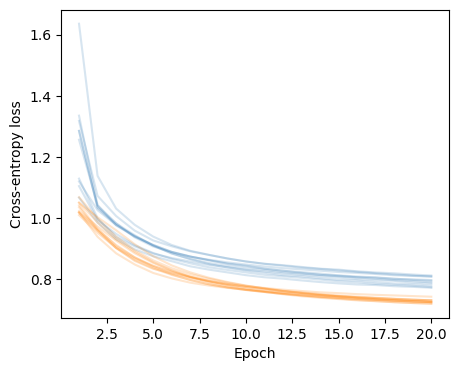

------------------------------ 
Training set:
Average log-likelihood = -581.9 (7.9)
Average accuracy       = 67.8% (1.0%)
Average F1 score       = 65.3% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -145.4 (1.3)
Average accuracy       = 68.6% (1.6%)
Average F1 score       = 65.9% (1.9%)
------------------------------ 
Test set:
Average log-likelihood = -349.1 (4.8)
Average accuracy       = 71.6% (1.5%)
Average F1 score       = 68.9% (2.4%)
------------------------------ 
Training set:
Strong regularity = 0.995 (0.006)
Weak regularity   = 0.996 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 0.996 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.994 (0.008)
Weak regularity   = 0.994 (0.008)
------------------------------


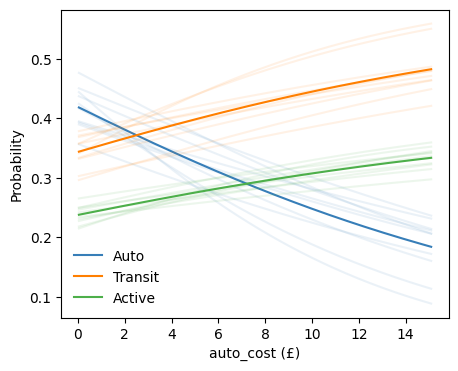

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -550.7 | acc = 69.9% | F1 = 68.6%
Validation set: LL = -142.6 | acc = 72.0% | F1 = 70.0%
Test set:       LL = -339.4 | acc = 71.8% | F1 = 70.5%
Model 2 
Training set:   LL = -547.8 | acc = 70.9% | F1 = 69.5%
Validation set: LL = -142.7 | acc = 71.0% | F1 = 69.1%
Test set:       LL = -338.8 | acc = 73.6% | F1 = 72.1%
Model 3 
Training set:   LL = -556.9 | acc = 70.2% | F1 = 68.9%
Validation set: LL = -141.6 | acc = 70.5% | F1 = 68.4%
Test set:       LL = -339.5 | acc = 73.0% | F1 = 71.7%
Model 4 
Training set:   LL = -554.9 | acc = 70.1% | F1 = 68.8%
Validation set: LL = -143.4 | acc = 70.5% | F1 = 68.0%
Test set:       LL = -342.7 | acc = 73.0% | F1 = 71.4%
Model 5 
Training set:   LL = -554.5 | acc = 69.5% | F1 = 67.8%
Validation set: LL = -141.3 | acc = 70.5% | F1 = 68.1%
Test set:       LL = -341.3 | acc = 73.4% | F1 = 72.0%
Model 6 
Training set:   LL = -558.9 | acc = 71.4% | F1 = 70.1%
Validation set: LL =

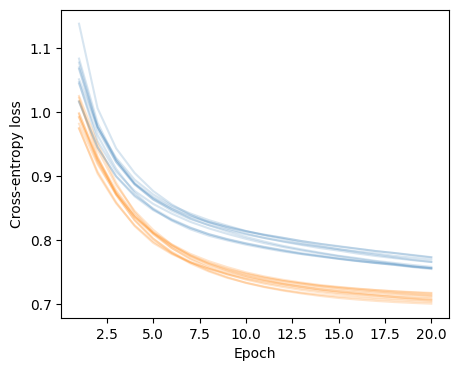

------------------------------ 
Training set:
Average log-likelihood = -553.5 (3.4)
Average accuracy       = 70.2% (0.5%)
Average F1 score       = 68.8% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -141.9 (1.1)
Average accuracy       = 70.5% (0.9%)
Average F1 score       = 68.4% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -340.1 (2.0)
Average accuracy       = 73.3% (0.6%)
Average F1 score       = 71.8% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.970 (0.009)
Weak regularity   = 0.986 (0.010)
------------------------------ 
Validation set:
Strong regularity = 0.972 (0.007)
Weak regularity   = 0.982 (0.012)
------------------------------ 
Test set:
Strong regularity = 0.965 (0.010)
Weak regularity   = 0.981 (0.013)
------------------------------


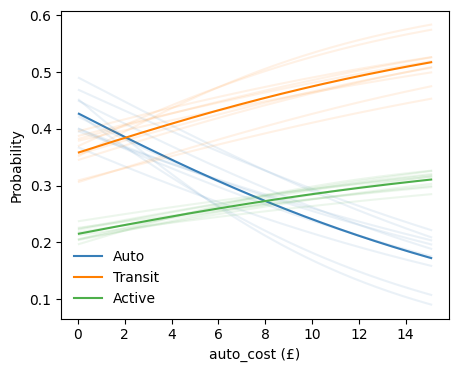

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -546.2 | acc = 69.2% | F1 = 67.9%
Validation set: LL = -143.8 | acc = 72.0% | F1 = 70.1%
Test set:       LL = -340.2 | acc = 73.0% | F1 = 71.8%
Model 2 
Training set:   LL = -543.1 | acc = 70.5% | F1 = 69.1%
Validation set: LL = -144.0 | acc = 71.0% | F1 = 68.8%
Test set:       LL = -342.3 | acc = 73.2% | F1 = 71.7%
Model 3 
Training set:   LL = -549.8 | acc = 70.5% | F1 = 69.3%
Validation set: LL = -142.5 | acc = 69.5% | F1 = 67.2%
Test set:       LL = -341.8 | acc = 74.0% | F1 = 72.7%
Model 4 
Training set:   LL = -547.3 | acc = 71.1% | F1 = 69.8%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -346.1 | acc = 73.4% | F1 = 72.0%
Model 5 
Training set:   LL = -547.8 | acc = 69.5% | F1 = 68.0%
Validation set: LL = -142.9 | acc = 69.0% | F1 = 66.4%
Test set:       LL = -345.4 | acc = 73.0% | F1 = 71.5%
Model 6 
Training set:   LL = -553.6 | acc = 70.4% | F1 = 69.0%
Validation set: LL 

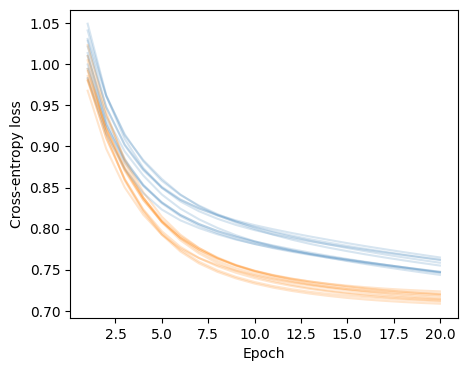

------------------------------ 
Training set:
Average log-likelihood = -547.2 (3.3)
Average accuracy       = 70.3% (0.6%)
Average F1 score       = 69.0% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -143.2 (0.9)
Average accuracy       = 70.1% (1.0%)
Average F1 score       = 68.0% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -342.9 (2.4)
Average accuracy       = 73.1% (0.5%)
Average F1 score       = 71.7% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.948 (0.017)
Weak regularity   = 0.952 (0.018)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.021)
Weak regularity   = 0.952 (0.022)
------------------------------ 
Test set:
Strong regularity = 0.942 (0.017)
Weak regularity   = 0.945 (0.020)
------------------------------


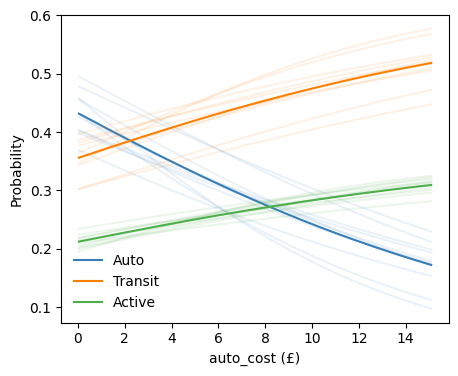

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -546.4 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.6 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.2 | acc = 72.4% | F1 = 71.1%
Model 2 
Training set:   LL = -543.6 | acc = 70.5% | F1 = 69.1%
Validation set: LL = -144.8 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.0 | acc = 73.4% | F1 = 72.1%
Model 3 
Training set:   LL = -550.4 | acc = 70.5% | F1 = 69.1%
Validation set: LL = -143.7 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -343.9 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -547.8 | acc = 71.0% | F1 = 69.9%
Validation set: LL = -145.2 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.6 | acc = 72.0% | F1 = 70.6%
Model 5 
Training set:   LL = -548.3 | acc = 69.9% | F1 = 68.4%
Validation set: LL = -144.1 | acc = 68.5% | F1 = 65.9%
Test set:       LL = -347.6 | acc = 72.6% | F1 = 71.2%
Model 6 
Training set:   LL = -554.2 | acc = 70.2% | F1 = 68.9%
Validation set: LL

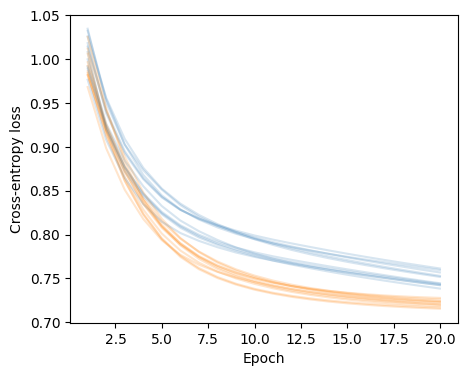

------------------------------ 
Training set:
Average log-likelihood = -547.8 (3.4)
Average accuracy       = 70.4% (0.3%)
Average F1 score       = 69.1% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -144.3 (0.8)
Average accuracy       = 69.7% (1.0%)
Average F1 score       = 67.6% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -344.8 (2.3)
Average accuracy       = 72.6% (0.5%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.022)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.025)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.940 (0.022)
Weak regularity   = 0.943 (0.023)
------------------------------


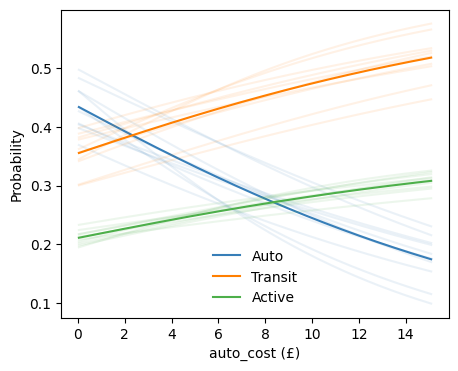

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.4 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.2 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 72.0% | F1 = 70.6%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.8% | F1 = 71.5%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

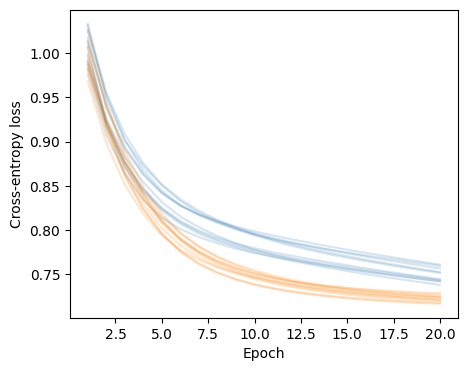

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.023)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.027)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


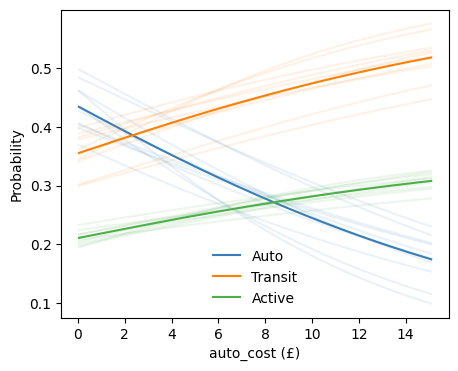

Penalty = 1e-06
------------------------------
Model 1 
Training set:   LL = -546.5 | acc = 70.2% | F1 = 69.0%
Validation set: LL = -144.7 | acc = 71.5% | F1 = 69.3%
Test set:       LL = -342.5 | acc = 72.6% | F1 = 71.3%
Model 2 
Training set:   LL = -543.7 | acc = 70.8% | F1 = 69.4%
Validation set: LL = -145.0 | acc = 70.5% | F1 = 68.3%
Test set:       LL = -344.2 | acc = 73.0% | F1 = 71.7%
Model 3 
Training set:   LL = -550.6 | acc = 70.2% | F1 = 68.8%
Validation set: LL = -143.9 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -344.3 | acc = 72.4% | F1 = 71.0%
Model 4 
Training set:   LL = -548.0 | acc = 71.5% | F1 = 70.4%
Validation set: LL = -145.4 | acc = 68.5% | F1 = 66.6%
Test set:       LL = -347.8 | acc = 71.8% | F1 = 70.4%
Model 5 
Training set:   LL = -548.5 | acc = 69.8% | F1 = 68.3%
Validation set: LL = -144.2 | acc = 69.0% | F1 = 66.7%
Test set:       LL = -347.8 | acc = 72.6% | F1 = 71.3%
Model 6 
Training set:   LL = -554.4 | acc = 70.2% | F1 = 68.9%
Validation set: LL 

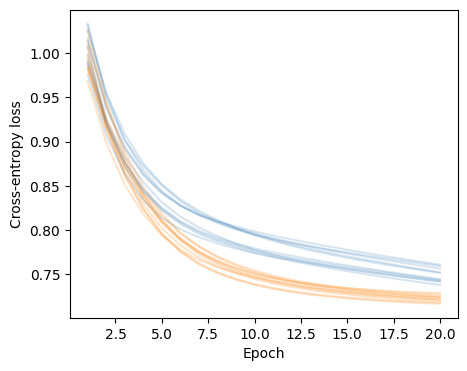

------------------------------ 
Training set:
Average log-likelihood = -548.0 (3.4)
Average accuracy       = 70.5% (0.5%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -144.5 (0.7)
Average accuracy       = 69.7% (0.9%)
Average F1 score       = 67.6% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -345.1 (2.3)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 71.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.023)
Weak regularity   = 0.950 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.949 (0.027)
Weak regularity   = 0.951 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.939 (0.023)
Weak regularity   = 0.943 (0.024)
------------------------------


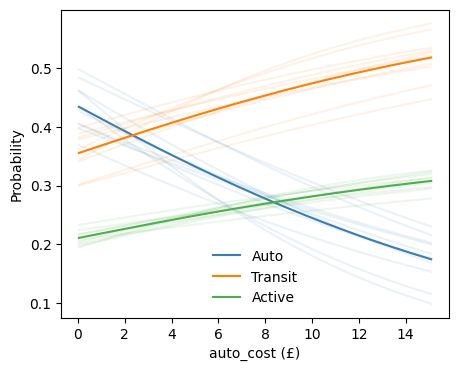

------------------------------ 
Model comparison:


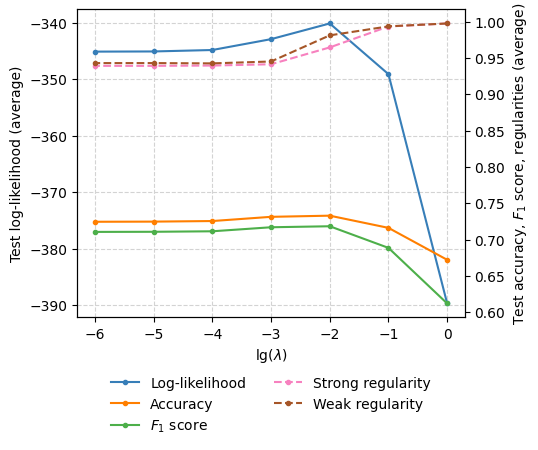

In [59]:
result(TasteNet, 20, 'LGR', [10**i for i in range(0, -7, -1)])

# Final results

In [60]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, sum-{GR}')].idxmax())
l_col.append('MNL')

In [61]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [62]:
results_train.to_csv(f'{path}/Regularity_results_L/1K_London_train.csv')
results_val.to_csv(f'{path}/Regularity_results_L/1K_London_val.csv')
results_test.to_csv(f'{path}/Regularity_results_L/1K_London_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results_L/1K_London_train_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results_L/1K_London_val_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results_L/1K_London_test_std.csv')

In [63]:
def gen_final_results(df, df_std):
    'Function to generate final results'
    df.iloc[0] = df.iloc[0].round(1)
    df = df.round(3)
    df_final = df.loc[df.index.repeat(2)]
    df_final.iloc[1::2] = df_std.applymap(lambda x: f'({round(x, 3)})')
    print(df_final.astype(str).to_latex())

In [64]:
gen_final_results(results_train, results_train_std)

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (1) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.01) & TasteNet, sum-LGR (0.01) & MNL \\
\midrule
Log-likelihood & -506.5 & -542.9 & -517.8 & -560.6 & -548.0 & -553.0 & -565.9 & -553.5 & -570.2 \\
Log-likelihood & (4.002) & (11.914) & (6.636) & (13.342) & (3.359) & (3.389) & (5.31) & (3.395) & (0) \\
Accuracy & 0.732 & 0.707 & 0.726 & 0.693 & 0.705 & 0.703 & 0.691 & 0.702 & 0.709 \\
Accuracy & (0.005) & (0.01) & (0.006) & (0.02) & (0.005) & (0.006) & (0.007) & (0.005) & (0) \\
F1 score & 0.727 & 0.694 & 0.72 & 0.673 & 0.691 & 0.689 & 0.672 & 0.688 & 0.701 \\
F1 score & (0.005) & (0.014) & (0.007) & (0.032) & (0.006) & (0.007) & (0.008) & (0.006) & (0) \\
Strong regularity & 0.898 & 0.999 & 0.991 & 0.999 & 0.946 & 0.968 & 0.998 & 0.97 & 1.0 \\
Strong regularity & (0.072) & (0.002) & (0.015) & (0.003) & (0.023) & (0.013) & (0.002) & (0.009) & (0) \\
Weak regularity & 0.906 &

In [65]:
gen_final_results(results_val, results_val_std)

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (1) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.01) & TasteNet, sum-LGR (0.01) & MNL \\
\midrule
Log-likelihood & -143.3 & -138.9 & -139.2 & -140.5 & -144.5 & -141.7 & -143.4 & -141.9 & -138.7 \\
Log-likelihood & (2.016) & (1.676) & (1.338) & (3.175) & (0.741) & (0.958) & (1.105) & (1.085) & (0) \\
Accuracy & 0.688 & 0.681 & 0.693 & 0.68 & 0.697 & 0.705 & 0.698 & 0.705 & 0.7 \\
Accuracy & (0.008) & (0.015) & (0.015) & (0.019) & (0.009) & (0.009) & (0.01) & (0.009) & (0) \\
F1 score & 0.683 & 0.663 & 0.685 & 0.653 & 0.676 & 0.684 & 0.676 & 0.684 & 0.689 \\
F1 score & (0.009) & (0.019) & (0.015) & (0.031) & (0.009) & (0.01) & (0.011) & (0.01) & (0) \\
Strong regularity & 0.89 & 0.998 & 0.988 & 0.997 & 0.949 & 0.97 & 0.998 & 0.972 & 1.0 \\
Strong regularity & (0.073) & (0.003) & (0.021) & (0.007) & (0.027) & (0.015) & (0.003) & (0.007) & (0) \\
Weak regularity & 0.896 & 0.99

In [66]:
gen_final_results(results_test, results_test_std)

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (1) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.01) & TasteNet, sum-LGR (0.01) & MNL \\
\midrule
Log-likelihood & -322.6 & -328.8 & -317.8 & -335.2 & -345.1 & -339.7 & -343.5 & -340.1 & -331.2 \\
Log-likelihood & (3.455) & (8.146) & (3.44) & (11.304) & (2.337) & (2.023) & (3.035) & (1.974) & (0) \\
Accuracy & 0.737 & 0.72 & 0.74 & 0.717 & 0.725 & 0.734 & 0.724 & 0.733 & 0.746 \\
Accuracy & (0.007) & (0.013) & (0.007) & (0.021) & (0.004) & (0.006) & (0.009) & (0.006) & (0) \\
F1 score & 0.732 & 0.703 & 0.734 & 0.694 & 0.711 & 0.72 & 0.705 & 0.718 & 0.74 \\
F1 score & (0.007) & (0.02) & (0.008) & (0.038) & (0.005) & (0.006) & (0.013) & (0.005) & (0) \\
Strong regularity & 0.904 & 0.999 & 0.992 & 0.997 & 0.939 & 0.964 & 0.999 & 0.965 & 0.998 \\
Strong regularity & (0.069) & (0.002) & (0.014) & (0.008) & (0.023) & (0.013) & (0.002) & (0.01) & (0) \\
Weak regularity & 0.913 & 